# Light Subsystem

### Requirements
Python 3.X


### Dependencies
scipy, matplotlib, numpy, jupyter

You can install all of these with the following command: pip3 install numpy scipy matplotlib

### Optimisation

This code will allow you to perform an optimisation on the light subsystem. The code below is a shortened version of the full source code available in this repository. The aim of this tutorial is not to go through every line of code and all the configurations that are possible, but demonstrate the optimisation environment leading to Fig. XX in the report. We start by importing the dependencies...

In [28]:
import time
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.optimize import minimize, BFGS, LinearConstraint

%matplotlib inline

I usually import the following classes from files to centralise them. To make the code clearer, I will go through them one by one.

The most important class is MP (ModelParameters). It holds the parameters and the constraints (in matrix form) for for the optimisation problem. Defining these parameters outside of the functions means we can adapt quickly to other room shapes, without having to change the function itself. 

I also define the Room class, which is a discretised representation of the room as a numpy meshgrid.

In [23]:
class MP:
    """
    Enum to hold some of the Model Parameters
    """

    """ 
    Global Parameters
    """

    # Discretisation step
    DXY = 0.01

    # Room geometry
    ROOM_LENGTH = 4
    ROOM_WIDTH = 3

    # Number of lamps
    N_LAMPS = 3

    # Parameters
    LAMP_EFFICIENCY = 0.8
    LAMP_RADII = [0.1, 0.2, 0.1]
    LAMP_POW = [50, 120, 50]

    # Albedo
    ALBEDO = 0.5
    BOUNCES = 3

    # Plot parameters
    N_LEVELS = 20

    """
    Light Quality Subsystem
    """

    # Initial lamp location guess (design variables: [x1, y1, x2, y2, x3, y3])
    INITIAL_GUESS_LAMP_LOCS = np.array([0.68978269, 0.98767149, 1.78447148, 2.79305784, 3.66072114, 2.4])

    # Linear Constraint Matrix
    CONSTRAINT_MAT = [[1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]]

    # Lamp 1: Bed: Bound Constraints (x1, y1)
    G1 = [LAMP_RADII[0], 2.3 - LAMP_RADII[0]]
    G2 = [LAMP_RADII[0], 1.5 - LAMP_RADII[0]]

    # Lamp 2: Floor: Bound Constraints (x2, y2)
    G3 = [0.4 + LAMP_RADII[1], 2.3 - LAMP_RADII[1]]
    G4 = [0.9 + LAMP_RADII[1], 3 - LAMP_RADII[1]]

    # Lamp 3: Desk: Bound Constraints (x3, y3)
    G5 = [2.3 + LAMP_RADII[2], 4 - LAMP_RADII[2]]
    G6 = [1.1 + LAMP_RADII[2], 3 - LAMP_RADII[2]]

    CONSTRAINTS = [G1, G2, G3, G4, G5, G6]

    # Linear Constraint Bounds
    LOWER_BOUND = [constraint[0] for constraint in CONSTRAINTS]
    UPPER_BOUND = [constraint[1] for constraint in CONSTRAINTS]

    
class Room:
    """
    The Room class contains the space in which the lighting optimisation will take place
    """

    def __init__(self, length, width):

        self.x = np.arange(0, length, MP.DXY)
        self.y = np.arange(0, width, MP.DXY)
        self.xx, self.yy = np.meshgrid(self.x, self.y, sparse=True)



Next we define the function that will determine the intensity distribution within the room. I am just demonstrating the intensity functions with reflection modelling here, meaning the function is slightly shorter compared to the  code in the repository. The function takes the location of the three lamps and returns the intensity distribution within the room, the global minimum, and the coordinates of the global minimum.


In [24]:
def get_intensity_distr(lamp_locs, refl=True):
    """
    Calculates the intensity distribution within a room with n number of light sources
    """

    room = Room(MP.ROOM_LENGTH, MP.ROOM_WIDTH)

    initialised = False

    # The first loop takes care of wall reflections
    for i in range(- MP.BOUNCES // 2, MP.BOUNCES // 2 + 1):
        # The second loop takes care of the three different lamps
        for j in range(MP.N_LAMPS):

            x_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j] + \
                   0.5 * (1 - (-1) ** i) * (MP.ROOM_LENGTH - lamp_locs[2 * j])
            y_jk = 0.5 * (1 + (-1) ** i) * lamp_locs[2 * j + 1] + \
                   0.5 * (1 - (-1) ** i) * (MP.ROOM_WIDTH - lamp_locs[2 * j + 1])

            distance_to_lamp_n = ((room.xx - (x_jk - MP.ROOM_LENGTH * i)) ** 2 +
                                  (room.yy - (y_jk - MP.ROOM_WIDTH * i)) ** 2)

            # Take out the value that are less than a radius away from the light source
            distance_to_lamp_n_filtered = ma.masked_less(np.sqrt(distance_to_lamp_n), MP.LAMP_RADII[j])

            # Initialise the light intensity array
            if not initialised:
                light_intensity = np.zeros_like(distance_to_lamp_n_filtered)
                initialised = True

            # Find light intensity distribution
            light_intensity_n = ((MP.ALBEDO ** (abs(2 * i))) * (MP.LAMP_EFFICIENCY * MP.LAMP_POW[j]) /
                                 (4 * np.pi)) / (distance_to_lamp_n_filtered * MP.DXY)

            # Increment light intensity array
            light_intensity += light_intensity_n

    minimum = np.amin(light_intensity)
    minimum_coordinates = np.unravel_index(np.argmin(light_intensity), light_intensity.shape)

    return light_intensity, minimum, minimum_coordinates


Now that we have the model parameters (MP), the room (Room) and the intensity distribution function, we can start building a model. In this example, I use SciPy's 'trust-constr' optimisation algorithm. The actual minimisation requires an initial guess of the solution, and some parameters that define how the Hessian and Jacobian are calculated. We estimate the Jacobian using a finite difference scheme for numerical estimation of the gradient ('3-point'). We use a Broyden-Fletcher-Goldfarb-Shanno (BFGS) Hessian update strategy, which is a quasi-Newton method and  seems to be very flexible.

In [26]:
class TrustConstrModel:
    """
    Two-dimensional model of light distribution in a plane with n number of light sources
    """

    def __init__(self):

        # To keep track of the iterations
        self.counter = 0

        # Parameters
        self.name = 'Trust-Constr'
        self.refl = True
        self.save_fig = False
        self.save_log = False
        self.constrained = True

        if self.save_log:
            self.data = []

        if self.constrained:
            self.constraints = LinearConstraint(MP.CONSTRAINT_MAT, MP.LOWER_BOUND, MP.UPPER_BOUND)
        else:
            self.constraints = ()

        print("Welcome! You are using a trust-constr optimiser.")
        print("Reflections: ", self.refl)
        print("Constraints: ", self.constrained)

        time.sleep(1)

        # Objective function. We want to maximise the minimum.
        self.result = minimize(self.obj_fun, MP.INITIAL_GUESS_LAMP_LOCS, method='trust-constr', jac='3-point',
                               constraints=self.constraints, hess=BFGS(exception_strategy='damp_update'))

        # What is the result of the optimisation?
        print(self.result)

    def obj_fun(self, vars):
        """
        Objective function to be minimised. This maximises the minimum of the light distribution.
        """

        # Calculate current intensity distribution
        light_intensity, minimum, minimum_coordinates = get_intensity_distr(vars, refl=self.refl)

        if self.save_log:
            self.data.append([light_intensity, minimum, minimum_coordinates])

        # Since we want to maximise the minimum, we need to minimise the negative function value
        print("Iteration: ", self.counter, " Variables: ", vars, " Minimum: ", minimum)
        self.counter += 1

        return -minimum


We have now defined everything we need and upon instatiating TrustConstrModel(), it will run the whole optimisation. minimize() does most of the job and repeatedly calls obj_fun(), with updated design variables (x_1, ..., x_6) on every new iteration. The objective function returns the negative minimum, meaning we are maximising that minimum. When done we print the result of the optimiser, and the result is stored in that instance of TrustConstrModel().

In [18]:
model = TrustConstrModel()

Welcome! You are using a trust-constr optimiser.
Reflections:  True
Constraints:  True
Iteration:  0  Variables:  [0.68978269 0.98767149 1.78447148 2.79305784 3.66072114 2.4       ]  Minimum:  587.6054104247064
Iteration:  1  Variables:  [0.68977663 0.98767149 1.78447148 2.79305784 3.66072114 2.4       ]  Minimum:  587.6052690140448
Iteration:  2  Variables:  [0.68978875 0.98767149 1.78447148 2.79305784 3.66072114 2.4       ]  Minimum:  587.6055518359174
Iteration:  3  Variables:  [0.68978269 0.98766543 1.78447148 2.79305784 3.66072114 2.4       ]  Minimum:  587.6054516398602
Iteration:  4  Variables:  [0.68978269 0.98767755 1.78447148 2.79305784 3.66072114 2.4       ]  Minimum:  587.6053692093302
Iteration:  5  Variables:  [0.68978269 0.98767149 1.78446067 2.79305784 3.66072114 2.4       ]  Minimum:  587.6049769989085
Iteration:  6  Variables:  [0.68978269 0.98767149 1.78448229 2.79305784 3.66072114 2.4       ]  Minimum:  587.6058438509168
Iteration:  7  Variables:  [0.68978269 0.9876

Iteration:  66  Variables:  [0.9529146  1.15703622 2.09697534 2.50747533 3.5754917  1.27400496]  Minimum:  718.664416398836
Iteration:  67  Variables:  [0.95292671 1.15703622 2.09697534 2.50747533 3.5754917  1.27400496]  Minimum:  718.6630623466383
Iteration:  68  Variables:  [0.95292066 1.15702921 2.09697534 2.50747533 3.5754917  1.27400496]  Minimum:  718.664693478513
Iteration:  69  Variables:  [0.95292066 1.15704322 2.09697534 2.50747533 3.5754917  1.27400496]  Minimum:  718.6627852706029
Iteration:  70  Variables:  [0.95292066 1.15703622 2.09696264 2.50747533 3.5754917  1.27400496]  Minimum:  718.6644257109732
Iteration:  71  Variables:  [0.95292066 1.15703622 2.09698804 2.50747533 3.5754917  1.27400496]  Minimum:  718.6630530347293
Iteration:  72  Variables:  [0.95292066 1.15703622 2.09697534 2.50746015 3.5754917  1.27400496]  Minimum:  718.6647516532669
Iteration:  73  Variables:  [0.95292066 1.15703622 2.09697534 2.50749052 3.5754917  1.27400496]  Minimum:  718.6627270960772
It

Iteration:  132  Variables:  [0.57656303 1.08339841 2.09696725 2.45591025 3.55282221 1.27400578]  Minimum:  714.3114253003884
Iteration:  133  Variables:  [0.57655698 1.08339185 2.09696725 2.45591025 3.55282221 1.27400578]  Minimum:  714.3113409503923
Iteration:  134  Variables:  [0.57655698 1.08340497 2.09696725 2.45591025 3.55282221 1.27400578]  Minimum:  714.3112522216304
Iteration:  135  Variables:  [0.57655698 1.08339841 2.09695455 2.45591025 3.55282221 1.27400578]  Minimum:  714.3106651048106
Iteration:  136  Variables:  [0.57655698 1.08339841 2.09697994 2.45591025 3.55282221 1.27400578]  Minimum:  714.3119280679464
Iteration:  137  Variables:  [0.57655698 1.08339841 2.09696725 2.45589538 3.55282221 1.27400578]  Minimum:  714.3121083020709
Iteration:  138  Variables:  [0.57655698 1.08339841 2.09696725 2.45592512 3.55282221 1.27400578]  Minimum:  714.3104848759536
Iteration:  139  Variables:  [0.57655698 1.08339841 2.09696725 2.45591025 3.5528007  1.27400578]  Minimum:  714.310095

Iteration:  201  Variables:  [0.91307294 1.13472188 2.09698703 2.463185   3.60520464 1.2740049 ]  Minimum:  720.4639661488649
Iteration:  202  Variables:  [0.91307294 1.13472188 2.09697433 2.46317009 3.60520464 1.2740049 ]  Minimum:  720.4654185925652
Iteration:  203  Variables:  [0.91307294 1.13472188 2.09697433 2.46319992 3.60520464 1.2740049 ]  Minimum:  720.4664604126009
Iteration:  204  Variables:  [0.91307294 1.13472188 2.09697433 2.463185   3.60518281 1.2740049 ]  Minimum:  720.466299366312
Iteration:  205  Variables:  [0.91307294 1.13472188 2.09697433 2.463185   3.60522647 1.2740049 ]  Minimum:  720.4655796566137
Iteration:  206  Variables:  [0.91307294 1.13472188 2.09697433 2.463185   3.60520464 1.27399718]  Minimum:  720.4658785900943
Iteration:  207  Variables:  [0.91307294 1.13472188 2.09697433 2.463185   3.60520464 1.27401261]  Minimum:  720.46600042861
Iteration:  208  Variables:  [0.85760604 1.17211672 2.09695575 2.46199773 3.62134102 1.2740075 ]  Minimum:  723.341629565

Iteration:  267  Variables:  [0.45016528 1.30571125 2.09665427 2.25146647 3.89897978 1.2740086 ]  Minimum:  734.3994183540731
Iteration:  268  Variables:  [0.45016528 1.30571125 2.09665427 2.25149374 3.89897978 1.2740086 ]  Minimum:  734.3977851229673
Iteration:  269  Variables:  [0.45016528 1.30571125 2.09665427 2.2514801  3.89895617 1.2740086 ]  Minimum:  734.3983034732814
Iteration:  270  Variables:  [0.45016528 1.30571125 2.09665427 2.2514801  3.89900339 1.2740086 ]  Minimum:  734.3988999148485
Iteration:  271  Variables:  [0.45016528 1.30571125 2.09665427 2.2514801  3.89897978 1.27400089]  Minimum:  734.4000781532083
Iteration:  272  Variables:  [0.45016528 1.30571125 2.09665427 2.2514801  3.89897978 1.27401632]  Minimum:  734.3971253371526
Iteration:  273  Variables:  [0.30688169 1.39952856 2.09642747 2.05760918 3.89895274 1.27401637]  Minimum:  738.8384984638362
Iteration:  274  Variables:  [0.30687563 1.39952856 2.09642747 2.05760918 3.89895274 1.27401637]  Minimum:  738.838632

Iteration:  334  Variables:  [0.31468101 1.39952675 2.09638119 2.11267748 3.89892334 1.27401626]  Minimum:  739.8739041112058
Iteration:  335  Variables:  [0.31468101 1.39952675 2.09638119 2.11267748 3.89897056 1.27401626]  Minimum:  739.8745007698765
Iteration:  336  Variables:  [0.31468101 1.39952675 2.09638119 2.11267748 3.89894695 1.27400854]  Minimum:  739.8756788823558
Iteration:  337  Variables:  [0.31468101 1.39952675 2.09638119 2.11267748 3.89894695 1.27402397]  Minimum:  739.8727261009527
Iteration:  338  Variables:  [0.17610679 1.39952242 2.09624486 1.85552723 3.89893381 1.27401413]  Minimum:  729.7671757265264
Iteration:  339  Variables:  [0.17610073 1.39952242 2.09624486 1.85552723 3.89893381 1.27401413]  Minimum:  729.7672534000908
Iteration:  340  Variables:  [0.17611284 1.39952242 2.09624486 1.85552723 3.89893381 1.27401413]  Minimum:  729.7670980501944
Iteration:  341  Variables:  [0.17610679 1.39951394 2.09624486 1.85552723 3.89893381 1.27401413]  Minimum:  729.766162

Iteration:  400  Variables:  [0.31314906 1.39952604 2.09637094 2.03182176 3.89896876 1.27572238]  Minimum:  737.3202289227922
Iteration:  401  Variables:  [0.31314906 1.39952604 2.09637094 2.03182176 3.89894515 1.27571465]  Minimum:  737.3205088755846
Iteration:  402  Variables:  [0.31314906 1.39952604 2.09637094 2.03182176 3.89894515 1.2757301 ]  Minimum:  737.3206143213695
Iteration:  403  Variables:  [0.31314906 1.39952604 2.09637094 2.03182176 3.89894515 1.27572238]  Minimum:  737.3205615985472
Iteration:  404  Variables:  [0.31314301 1.39952604 2.09637094 2.03182176 3.89894515 1.27572238]  Minimum:  737.3206986305811
Iteration:  405  Variables:  [0.31315512 1.39952604 2.09637094 2.03182176 3.89894515 1.27572238]  Minimum:  737.3204245640588
Iteration:  406  Variables:  [0.31314906 1.39951757 2.09637094 2.03182176 3.89894515 1.27572238]  Minimum:  737.3195877140362
Iteration:  407  Variables:  [0.31314906 1.39953452 2.09637094 2.03182176 3.89894515 1.27572238]  Minimum:  737.321535

Iteration:  470  Variables:  [0.27432339 1.39952603 2.09627543 2.1019861  3.89893971 1.26893061]  Minimum:  740.8528525256067
Iteration:  471  Variables:  [0.27431734 1.39951755 2.09627543 2.1019861  3.89893971 1.26893061]  Minimum:  740.8528108562132
Iteration:  472  Variables:  [0.27431734 1.3995345  2.09627543 2.1019861  3.89893971 1.26893061]  Minimum:  740.8526951702319
Iteration:  473  Variables:  [0.27431734 1.39952603 2.09626273 2.1019861  3.89893971 1.26893061]  Minimum:  740.8519442658146
Iteration:  474  Variables:  [0.27431734 1.39952603 2.09628812 2.1019861  3.89893971 1.26893061]  Minimum:  740.853561762787
Iteration:  475  Variables:  [0.27431734 1.39952603 2.09627543 2.10197337 3.89893971 1.26893061]  Minimum:  740.8535636819673
Iteration:  476  Variables:  [0.27431734 1.39952603 2.09627543 2.10199883 3.89893971 1.26893061]  Minimum:  740.851942348775
Iteration:  477  Variables:  [0.27431734 1.39952603 2.09627543 2.1019861  3.8989161  1.26893061]  Minimum:  740.85245069

Iteration:  538  Variables:  [0.31004043 1.39952638 2.09635655 2.10924628 3.89894578 1.26730957]  Minimum:  741.3027530570433
Iteration:  539  Variables:  [0.31004043 1.39952638 2.09638194 2.10924628 3.89894578 1.26730957]  Minimum:  741.3043620517395
Iteration:  540  Variables:  [0.31004043 1.39952638 2.09636925 2.1092335  3.89894578 1.26730957]  Minimum:  741.3043687580074
Iteration:  541  Variables:  [0.31004043 1.39952638 2.09636925 2.10925905 3.89894578 1.26730957]  Minimum:  741.3027463529933
Iteration:  542  Variables:  [0.31004043 1.39952638 2.09636925 2.10924628 3.89892217 1.26730957]  Minimum:  741.3032539867737
Iteration:  543  Variables:  [0.31004043 1.39952638 2.09636925 2.10924628 3.89896939 1.26730957]  Minimum:  741.3038610347248
Iteration:  544  Variables:  [0.31004043 1.39952638 2.09636925 2.10924628 3.89894578 1.2673019 ]  Minimum:  741.3050419784769
Iteration:  545  Variables:  [0.31004043 1.39952638 2.09636925 2.10924628 3.89894578 1.26731724]  Minimum:  741.302073

Iteration:  607  Variables:  [0.31132764 1.39952638 2.09636965 2.10689476 3.89892222 1.26756873]  Minimum:  741.3129587932336
Iteration:  608  Variables:  [0.31132764 1.39952638 2.09636965 2.10689476 3.89896944 1.26756873]  Minimum:  741.3122945767014
Iteration:  609  Variables:  [0.31132764 1.39952638 2.09636965 2.10689476 3.89894583 1.26756105]  Minimum:  741.3125741503069
Iteration:  610  Variables:  [0.31132764 1.39952638 2.09636965 2.10689476 3.89894583 1.2675764 ]  Minimum:  741.312679215164
Iteration:  611  Variables:  [0.31132764 1.39952638 2.09636965 2.10689476 3.89894583 1.26756873]  Minimum:  741.312626682804
Iteration:  612  Variables:  [0.31132158 1.39952638 2.09636965 2.10689476 3.89894583 1.26756873]  Minimum:  741.3127629758133
Iteration:  613  Variables:  [0.3113337  1.39952638 2.09636965 2.10689476 3.89894583 1.26756873]  Minimum:  741.3124903873348
Iteration:  614  Variables:  [0.31132764 1.39951791 2.09636965 2.10689476 3.89894583 1.26756873]  Minimum:  741.31165214

Iteration:  677  Variables:  [0.31122324 1.39952639 2.09636952 2.1073118  3.89894586 1.26782002]  Minimum:  741.3384545839142
Iteration:  678  Variables:  [0.31123535 1.39952639 2.09636952 2.1073118  3.89894586 1.26782002]  Minimum:  741.3381820753303
Iteration:  679  Variables:  [0.3112293  1.39951791 2.09636952 2.1073118  3.89894586 1.26782002]  Minimum:  741.3373437613837
Iteration:  680  Variables:  [0.3112293  1.39953486 2.09636952 2.1073118  3.89894586 1.26782002]  Minimum:  741.3392929105905
Iteration:  681  Variables:  [0.3112293  1.39952639 2.09635683 2.1073118  3.89894586 1.26782002]  Minimum:  741.3400132158883
Iteration:  682  Variables:  [0.3112293  1.39952639 2.09638221 2.1073118  3.89894586 1.26782002]  Minimum:  741.3366234621942
Iteration:  683  Variables:  [0.3112293  1.39952639 2.09636952 2.10729904 3.89894586 1.26782002]  Minimum:  741.3376531811825
Iteration:  684  Variables:  [0.3112293  1.39952639 2.09636952 2.10732456 3.89894586 1.26782002]  Minimum:  741.338983

Iteration:  747  Variables:  [0.31128496 1.39952638 2.09637627 2.10768218 3.89894528 1.26770152]  Minimum:  741.3484746009335
Iteration:  748  Variables:  [0.31128496 1.39952638 2.09636357 2.10766942 3.89894528 1.26770152]  Minimum:  741.3484802810626
Iteration:  749  Variables:  [0.31128496 1.39952638 2.09636357 2.10769494 3.89894528 1.26770152]  Minimum:  741.3468580859987
Iteration:  750  Variables:  [0.31128496 1.39952638 2.09636357 2.10768218 3.89892167 1.26770152]  Minimum:  741.3473659194407
Iteration:  751  Variables:  [0.31128496 1.39952638 2.09636357 2.10768218 3.89896889 1.26770152]  Minimum:  741.3479723582044
Iteration:  752  Variables:  [0.31128496 1.39952638 2.09636357 2.10768218 3.89894528 1.26769385]  Minimum:  741.3491531351597
Iteration:  753  Variables:  [0.31128496 1.39952638 2.09636357 2.10768218 3.89894528 1.2677092 ]  Minimum:  741.3461852460357
Iteration:  754  Variables:  [0.31134078 1.39952635 2.0963629  2.10813571 3.89894518 1.26745458]  Minimum:  741.367489

Iteration:  815  Variables:  [0.32640887 1.39951503 2.09595923 2.2312505  3.89888407 1.2002354 ]  Minimum:  741.9920349874864
Iteration:  816  Variables:  [0.32640887 1.39951503 2.09595923 2.2312505  3.89893129 1.2002354 ]  Minimum:  741.9910130972582
Iteration:  817  Variables:  [0.32640887 1.39951503 2.09595923 2.2312505  3.89890768 1.20022813]  Minimum:  741.991564518534
Iteration:  818  Variables:  [0.32640887 1.39951503 2.09595923 2.2312505  3.89890768 1.20024267]  Minimum:  741.9914835602563
Iteration:  819  Variables:  [0.31882297 1.39948562 2.09435679 2.17504105 3.89880123 1.22917542]  Minimum:  744.6217607692147
Iteration:  820  Variables:  [0.31881692 1.39948562 2.09435679 2.17504105 3.89880123 1.22917542]  Minimum:  744.6219000834361
Iteration:  821  Variables:  [0.31882903 1.39948562 2.09435679 2.17504105 3.89880123 1.22917542]  Minimum:  744.6216214525546
Iteration:  822  Variables:  [0.31882297 1.39947714 2.09435679 2.17504105 3.89880123 1.22917542]  Minimum:  744.6207890

Iteration:  881  Variables:  [0.29207463 1.39922866 2.03949066 2.13112991 3.89781856 1.20030422]  Minimum:  749.7687054651452
Iteration:  882  Variables:  [0.29207463 1.39922866 2.03949066 2.13112991 3.89779496 1.20029695]  Minimum:  749.7699076319402
Iteration:  883  Variables:  [0.29207463 1.39922866 2.03949066 2.13112991 3.89779496 1.20031149]  Minimum:  749.7667698854299
Iteration:  884  Variables:  [0.27737646 1.39922202 2.015337   2.08803848 3.89774637 1.20030815]  Minimum:  750.6152900268507
Iteration:  885  Variables:  [0.2773704  1.39922202 2.015337   2.08803848 3.89774637 1.20030815]  Minimum:  750.6151903257361
Iteration:  886  Variables:  [0.27738251 1.39922202 2.015337   2.08803848 3.89774637 1.20030815]  Minimum:  750.6153897283272
Iteration:  887  Variables:  [0.27737646 1.39921355 2.015337   2.08803848 3.89774637 1.20030815]  Minimum:  750.6153479429523
Iteration:  888  Variables:  [0.27737646 1.39923049 2.015337   2.08803848 3.89774637 1.20030815]  Minimum:  750.615232

Iteration:  949  Variables:  [0.17554656 1.39918543 1.84802295 1.78919302 3.89758631 1.20032255]  Minimum:  755.1442861149798
Iteration:  950  Variables:  [0.17554051 1.39918543 1.84802295 1.78919302 3.89758631 1.20032255]  Minimum:  755.1441923701672
Iteration:  951  Variables:  [0.17555262 1.39918543 1.84802295 1.78919302 3.89758631 1.20032255]  Minimum:  755.1443798601393
Iteration:  952  Variables:  [0.17554656 1.39917695 1.84802295 1.78919302 3.89758631 1.20032255]  Minimum:  755.144341085943
Iteration:  953  Variables:  [0.17554656 1.3991939  1.84802295 1.78919302 3.89758631 1.20032255]  Minimum:  755.1442311437736
Iteration:  954  Variables:  [0.17554656 1.39918543 1.84801176 1.78919302 3.89758631 1.20032255]  Minimum:  755.143458401076
Iteration:  955  Variables:  [0.17554656 1.39918543 1.84803414 1.78919302 3.89758631 1.20032255]  Minimum:  755.1451138323583
Iteration:  956  Variables:  [0.17554656 1.39918543 1.84802295 1.78918219 3.89758631 1.20032255]  Minimum:  755.14490577

Iteration:  1015  Variables:  [0.16957982 1.39919543 1.83694137 1.77185163 3.89760417 1.20032021]  Minimum:  755.2187735815679
Iteration:  1016  Variables:  [0.16959193 1.39919543 1.83694137 1.77185163 3.89760417 1.20032021]  Minimum:  755.2189603883069
Iteration:  1017  Variables:  [0.16958588 1.39918696 1.83694137 1.77185163 3.89760417 1.20032021]  Minimum:  755.2189217972268
Iteration:  1018  Variables:  [0.16958588 1.3992039  1.83694137 1.77185163 3.89760417 1.20032021]  Minimum:  755.2188121720592
Iteration:  1019  Variables:  [0.16958588 1.39919543 1.83693025 1.77185163 3.89760417 1.20032021]  Minimum:  755.218038273261
Iteration:  1020  Variables:  [0.16958588 1.39919543 1.83695249 1.77185163 3.89760417 1.20032021]  Minimum:  755.219695699807
Iteration:  1021  Variables:  [0.16958588 1.39919543 1.83694137 1.7718409  3.89760417 1.20032021]  Minimum:  755.2194766278416
Iteration:  1022  Variables:  [0.16958588 1.39919543 1.83694137 1.77186236 3.89760417 1.20032021]  Minimum:  755.

Iteration:  1083  Variables:  [0.16923987 1.39920388 1.83759745 1.85180325 3.89760292 1.20032034]  Minimum:  750.7487461728824
Iteration:  1084  Variables:  [0.16923987 1.39919541 1.83758632 1.85180325 3.89760292 1.20032034]  Minimum:  750.7480141804659
Iteration:  1085  Variables:  [0.16923987 1.39919541 1.83760858 1.85180325 3.89760292 1.20032034]  Minimum:  750.7495877754008
Iteration:  1086  Variables:  [0.16923987 1.39919541 1.83759745 1.85179204 3.89760292 1.20032034]  Minimum:  750.7494292783324
Iteration:  1087  Variables:  [0.16923987 1.39919541 1.83759745 1.85181446 3.89760292 1.20032034]  Minimum:  750.7481726758505
Iteration:  1088  Variables:  [0.16923987 1.39919541 1.83759745 1.85180325 3.89757932 1.20032034]  Minimum:  750.7484333800368
Iteration:  1089  Variables:  [0.16923987 1.39919541 1.83759745 1.85180325 3.89762652 1.20032034]  Minimum:  750.7491684726872
Iteration:  1090  Variables:  [0.16923987 1.39919541 1.83759745 1.85180325 3.89760292 1.20031307]  Minimum:  75

Iteration:  1151  Variables:  [0.16948377 1.39919542 1.83785145 1.78153333 3.89760407 1.20032022]  Minimum:  754.7349975873817
Iteration:  1152  Variables:  [0.16948377 1.39919542 1.83785145 1.78155491 3.89760407 1.20032022]  Minimum:  754.7337726485271
Iteration:  1153  Variables:  [0.16948377 1.39919542 1.83785145 1.78154412 3.89758047 1.20032022]  Minimum:  754.7340175256859
Iteration:  1154  Variables:  [0.16948377 1.39919542 1.83785145 1.78154412 3.89762767 1.20032022]  Minimum:  754.7347526090548
Iteration:  1155  Variables:  [0.16948377 1.39919542 1.83785145 1.78154412 3.89760407 1.20031295]  Minimum:  754.7359539210895
Iteration:  1156  Variables:  [0.16948377 1.39919542 1.83785145 1.78154412 3.89760407 1.20032749]  Minimum:  754.7328163328799
Iteration:  1157  Variables:  [0.16948377 1.39919542 1.83785145 1.78154412 3.89760407 1.20032022]  Minimum:  754.7343851173973
Iteration:  1158  Variables:  [0.16947772 1.39919542 1.83785145 1.78154412 3.89760407 1.20032022]  Minimum:  75

Iteration:  1219  Variables:  [0.16950884 1.39919542 1.83785231 1.77401597 3.89762779 1.20032021]  Minimum:  755.1628720733179
Iteration:  1220  Variables:  [0.16950884 1.39919542 1.83785231 1.77401597 3.89760419 1.20031294]  Minimum:  755.1640733859069
Iteration:  1221  Variables:  [0.16950884 1.39919542 1.83785231 1.77401597 3.89760419 1.20032747]  Minimum:  755.1609357975884
Iteration:  1222  Variables:  [0.16951528 1.39919542 1.83785128 1.77276171 3.89760421 1.2003202 ]  Minimum:  755.2338333153996
Iteration:  1223  Variables:  [0.16950922 1.39919542 1.83785128 1.77276171 3.89760421 1.2003202 ]  Minimum:  755.2337399162424
Iteration:  1224  Variables:  [0.16952134 1.39919542 1.83785128 1.77276171 3.89760421 1.2003202 ]  Minimum:  755.2339267149034
Iteration:  1225  Variables:  [0.16951528 1.39918695 1.83785128 1.77276171 3.89760421 1.2003202 ]  Minimum:  755.2338881259845
Iteration:  1226  Variables:  [0.16951528 1.39920389 1.83785128 1.77276171 3.89760421 1.2003202 ]  Minimum:  75

Iteration:  1289  Variables:  [0.16951462 1.39919542 1.83786307 1.77153314 3.8976042  1.2003202 ]  Minimum:  755.2452251615147
Iteration:  1290  Variables:  [0.16950857 1.39918694 1.83786307 1.77153314 3.8976042  1.2003202 ]  Minimum:  755.2442856767592
Iteration:  1291  Variables:  [0.16950857 1.39920389 1.83786307 1.77153314 3.8976042  1.2003202 ]  Minimum:  755.2463138705263
Iteration:  1292  Variables:  [0.16950857 1.39919542 1.83785194 1.77153314 3.8976042  1.2003202 ]  Minimum:  755.2467377312498
Iteration:  1293  Variables:  [0.16950857 1.39919542 1.83787419 1.77153314 3.8976042  1.2003202 ]  Minimum:  755.2438618145811
Iteration:  1294  Variables:  [0.16950857 1.39919542 1.83786307 1.77152241 3.8976042  1.2003202 ]  Minimum:  755.2444334820744
Iteration:  1295  Variables:  [0.16950857 1.39919542 1.83786307 1.77154387 3.8976042  1.2003202 ]  Minimum:  755.2461660536108
Iteration:  1296  Variables:  [0.16950857 1.39919542 1.83786307 1.77153314 3.8975806  1.2003202 ]  Minimum:  75

Iteration:  1355  Variables:  [0.16950431 1.39918693 1.83792152 1.77210132 3.89760414 1.20032021]  Minimum:  755.2765001628408
Iteration:  1356  Variables:  [0.16950431 1.39920387 1.83792152 1.77210132 3.89760414 1.20032021]  Minimum:  755.2763905420144
Iteration:  1357  Variables:  [0.16950431 1.3991954  1.83791039 1.77210132 3.89760414 1.20032021]  Minimum:  755.2756160228762
Iteration:  1358  Variables:  [0.16950431 1.3991954  1.83793265 1.77210132 3.89760414 1.20032021]  Minimum:  755.2772746857634
Iteration:  1359  Variables:  [0.16950431 1.3991954  1.83792152 1.77209059 3.89760414 1.20032021]  Minimum:  755.2770555712884
Iteration:  1360  Variables:  [0.16950431 1.3991954  1.83792152 1.77211205 3.89760414 1.20032021]  Minimum:  755.2758351348853
Iteration:  1361  Variables:  [0.16950431 1.3991954  1.83792152 1.77210132 3.89758054 1.20032021]  Minimum:  755.2760777611414
Iteration:  1362  Variables:  [0.16950431 1.3991954  1.83792152 1.77210132 3.89762775 1.20032021]  Minimum:  75

Iteration:  1424  Variables:  [0.16942344 1.39919533 1.83768351 1.77165805 3.89760391 1.20032023]  Minimum:  755.2796322023918
Iteration:  1425  Variables:  [0.16942344 1.39919533 1.83768351 1.77167951 3.89760391 1.20032023]  Minimum:  755.2813652657373
Iteration:  1426  Variables:  [0.16942344 1.39919533 1.83768351 1.77166878 3.89758031 1.20032023]  Minimum:  755.2808262668982
Iteration:  1427  Variables:  [0.16942344 1.39919533 1.83768351 1.77166878 3.89762751 1.20032023]  Minimum:  755.2801712058996
Iteration:  1428  Variables:  [0.16942344 1.39919533 1.83768351 1.77166878 3.89760391 1.20031296]  Minimum:  755.2804478711602
Iteration:  1429  Variables:  [0.16942344 1.39919533 1.83768351 1.77166878 3.89760391 1.2003275 ]  Minimum:  755.2804782168001
Iteration:  1430  Variables:  [0.16941925 1.39919532 1.83772182 1.77173869 3.89760391 1.20032023]  Minimum:  755.2808629567742
Iteration:  1431  Variables:  [0.1694132  1.39919532 1.83772182 1.77173869 3.89760391 1.20032023]  Minimum:  75

Iteration:  1491  Variables:  [0.16950419 1.39919522 1.83647849 1.76990626 3.89757993 1.20032027]  Minimum:  755.2930387722563
Iteration:  1492  Variables:  [0.16950419 1.39919522 1.83647849 1.76990626 3.89762714 1.20032027]  Minimum:  755.2923837111829
Iteration:  1493  Variables:  [0.16950419 1.39919522 1.83647849 1.76990626 3.89760353 1.200313  ]  Minimum:  755.2926603764718
Iteration:  1494  Variables:  [0.16950419 1.39919522 1.83647849 1.76990626 3.89760353 1.20032754]  Minimum:  755.2920432699383
Iteration:  1495  Variables:  [0.1694573  1.3991952  1.83677218 1.77034438 3.89760341 1.20032028]  Minimum:  755.2898921609598
Iteration:  1496  Variables:  [0.16945124 1.3991952  1.83677218 1.77034438 3.89760341 1.20032028]  Minimum:  755.2897987651156
Iteration:  1497  Variables:  [0.16946335 1.3991952  1.83677218 1.77034438 3.89760341 1.20032028]  Minimum:  755.2899855571503
Iteration:  1498  Variables:  [0.1694573  1.39918673 1.83677218 1.77034438 3.89760341 1.20032028]  Minimum:  75

Iteration:  1560  Variables:  [0.16952822 1.39919521 1.83645011 1.76993653 3.89760351 1.20032027]  Minimum:  755.2901462547355
Iteration:  1561  Variables:  [0.16952217 1.39919521 1.83645011 1.76993653 3.89760351 1.20032027]  Minimum:  755.2900528548339
Iteration:  1562  Variables:  [0.16953428 1.39919521 1.83645011 1.76993653 3.89760351 1.20032027]  Minimum:  755.2902396549838
Iteration:  1563  Variables:  [0.16952822 1.39918674 1.83645011 1.76993653 3.89760351 1.20032027]  Minimum:  755.2902010656506
Iteration:  1564  Variables:  [0.16952822 1.39920369 1.83645011 1.76993653 3.89760351 1.20032027]  Minimum:  755.2900914435779
Iteration:  1565  Variables:  [0.16952822 1.39919521 1.83643899 1.76993653 3.89760351 1.20032027]  Minimum:  755.2893168791853
Iteration:  1566  Variables:  [0.16952822 1.39919521 1.83646123 1.76993653 3.89760351 1.20032027]  Minimum:  755.2909756338352
Iteration:  1567  Variables:  [0.16952822 1.39919521 1.83645011 1.76992581 3.89760351 1.20032027]  Minimum:  75

Iteration:  1627  Variables:  [0.16951016 1.39919522 1.83647641 1.76992781 3.89760353 1.20032027]  Minimum:  755.2923244796668
Iteration:  1628  Variables:  [0.16950411 1.39918675 1.83647641 1.76992781 3.89760353 1.20032027]  Minimum:  755.2922858910727
Iteration:  1629  Variables:  [0.16950411 1.39920369 1.83647641 1.76992781 3.89760353 1.20032027]  Minimum:  755.2921762702815
Iteration:  1630  Variables:  [0.16950411 1.39919522 1.83646529 1.76992781 3.89760353 1.20032027]  Minimum:  755.2914016802362
Iteration:  1631  Variables:  [0.16950411 1.39919522 1.83648753 1.76992781 3.89760353 1.20032027]  Minimum:  755.2930604849098
Iteration:  1632  Variables:  [0.16950411 1.39919522 1.83647641 1.76991709 3.89760353 1.20032027]  Minimum:  755.292840009282
Iteration:  1633  Variables:  [0.16950411 1.39919522 1.83647641 1.76993853 3.89760353 1.20032027]  Minimum:  755.2916221533762
Iteration:  1634  Variables:  [0.16950411 1.39919522 1.83647641 1.76992781 3.89757993 1.20032027]  Minimum:  755

Iteration:  1694  Variables:  [0.16951402 1.39920368 1.83647683 1.76991651 3.89760351 1.20032027]  Minimum:  755.293001506408
Iteration:  1695  Variables:  [0.16951402 1.39919521 1.83646571 1.76991651 3.89760351 1.20032027]  Minimum:  755.2922269101507
Iteration:  1696  Variables:  [0.16951402 1.39919521 1.83648795 1.76991651 3.89760351 1.20032027]  Minimum:  755.2921972617866
Iteration:  1697  Variables:  [0.16951402 1.39919521 1.83647683 1.7699058  3.89760351 1.20032027]  Minimum:  755.2927665895802
Iteration:  1698  Variables:  [0.16951402 1.39919521 1.83647683 1.76992723 3.89760351 1.20032027]  Minimum:  755.2924473923127
Iteration:  1699  Variables:  [0.16951402 1.39919521 1.83647683 1.76991651 3.89757991 1.20032027]  Minimum:  755.2926887232182
Iteration:  1700  Variables:  [0.16951402 1.39919521 1.83647683 1.76991651 3.89762711 1.20032027]  Minimum:  755.293306065241
Iteration:  1701  Variables:  [0.16951402 1.39919521 1.83647683 1.76991651 3.89760351 1.200313  ]  Minimum:  755.

Iteration:  1760  Variables:  [0.16951366 1.39919521 1.83646503 1.76991078 3.89760351 1.20032027]  Minimum:  755.2924968253681
Iteration:  1761  Variables:  [0.16951366 1.39919521 1.83648727 1.76991078 3.89760351 1.20032027]  Minimum:  755.2918248943467
Iteration:  1762  Variables:  [0.16951366 1.39919521 1.83647615 1.76990006 3.89760351 1.20032027]  Minimum:  755.2923942178901
Iteration:  1763  Variables:  [0.16951366 1.39919521 1.83647615 1.7699215  3.89760351 1.20032027]  Minimum:  755.2927173118906
Iteration:  1764  Variables:  [0.16951366 1.39919521 1.83647615 1.76991078 3.89757991 1.20032027]  Minimum:  755.2929586410352
Iteration:  1765  Variables:  [0.16951366 1.39919521 1.83647615 1.76991078 3.89762711 1.20032027]  Minimum:  755.2929336916961
Iteration:  1766  Variables:  [0.16951366 1.39919521 1.83647615 1.76991078 3.89760351 1.200313  ]  Minimum:  755.293210356987
Iteration:  1767  Variables:  [0.16951366 1.39919521 1.83647615 1.76991078 3.89760351 1.20032754]  Minimum:  755

Iteration:  1826  Variables:  [0.1695136  1.39919521 1.83648588 1.76991081 3.89760351 1.20032027]  Minimum:  755.2920084982255
Iteration:  1827  Variables:  [0.1695136  1.39919521 1.83647475 1.76990009 3.89760351 1.20032027]  Minimum:  755.2925778204534
Iteration:  1828  Variables:  [0.1695136  1.39919521 1.83647475 1.76992153 3.89760351 1.20032027]  Minimum:  755.2926105374095
Iteration:  1829  Variables:  [0.1695136  1.39919521 1.83647475 1.76991081 3.89757991 1.20032027]  Minimum:  755.2928518658262
Iteration:  1830  Variables:  [0.1695136  1.39919521 1.83647475 1.76991081 3.89762711 1.20032027]  Minimum:  755.2931172957201
Iteration:  1831  Variables:  [0.1695136  1.39919521 1.83647475 1.76991081 3.89760351 1.200313  ]  Minimum:  755.293393961011
Iteration:  1832  Variables:  [0.1695136  1.39919521 1.83647475 1.76991081 3.89760351 1.20032754]  Minimum:  755.2916506755233
Iteration:  1833  Variables:  [0.1695136  1.39919521 1.83647475 1.76991081 3.89760351 1.20032027]  Minimum:  755

Iteration:  1894  Variables:  [0.16951361 1.39919521 1.83647369 1.76990917 3.89757991 1.20032027]  Minimum:  755.2928655825768
Iteration:  1895  Variables:  [0.16951361 1.39919521 1.83647369 1.76990917 3.89762711 1.20032027]  Minimum:  755.2931222626555
Iteration:  1896  Variables:  [0.16951361 1.39919521 1.83647369 1.76990917 3.89760351 1.200313  ]  Minimum:  755.2933989279463
Iteration:  1897  Variables:  [0.16951361 1.39919521 1.83647369 1.76990917 3.89760351 1.20032754]  Minimum:  755.2916643922752
Iteration:  1898  Variables:  [0.16951361 1.39919521 1.83647369 1.76990917 3.89760351 1.20032027]  Minimum:  755.2932331765512
Iteration:  1899  Variables:  [0.16950756 1.39919521 1.83647369 1.76990917 3.89760351 1.20032027]  Minimum:  755.2931397774853
Iteration:  1900  Variables:  [0.16951967 1.39919521 1.83647369 1.76990917 3.89760351 1.20032027]  Minimum:  755.2933265759636
Iteration:  1901  Variables:  [0.16951361 1.39918674 1.83647369 1.76990917 3.89760351 1.20032027]  Minimum:  75

Iteration:  1960  Variables:  [0.16951365 1.39919521 1.83647516 1.76991104 3.89762711 1.20032027]  Minimum:  755.2930826482027
Iteration:  1961  Variables:  [0.16951365 1.39919521 1.83647516 1.76991104 3.89760351 1.200313  ]  Minimum:  755.2933593134936
Iteration:  1962  Variables:  [0.16951365 1.39919521 1.83647516 1.76991104 3.89760351 1.20032754]  Minimum:  755.2916686845927
Iteration:  1963  Variables:  [0.16951365 1.39919521 1.83647516 1.76991104 3.89760351 1.20032027]  Minimum:  755.2932374688693
Iteration:  1964  Variables:  [0.16950759 1.39919521 1.83647516 1.76991104 3.89760351 1.20032027]  Minimum:  755.2931440698013
Iteration:  1965  Variables:  [0.1695197  1.39919521 1.83647516 1.76991104 3.89760351 1.20032027]  Minimum:  755.2933308682834
Iteration:  1966  Variables:  [0.16951365 1.39918674 1.83647516 1.76991104 3.89760351 1.20032027]  Minimum:  755.292396086791
Iteration:  1967  Variables:  [0.16951365 1.39920368 1.83647516 1.76991104 3.89760351 1.20032027]  Minimum:  755

Iteration:  2025  Variables:  [0.16951364 1.39919521 1.83647548 1.76991057 3.89762711 1.20032027]  Minimum:  755.2930039507111
Iteration:  2026  Variables:  [0.16951364 1.39919521 1.83647548 1.76991057 3.89760351 1.200313  ]  Minimum:  755.2932806160019
Iteration:  2027  Variables:  [0.16951364 1.39919521 1.83647548 1.76991057 3.89760351 1.20032754]  Minimum:  755.2917188966641
Iteration:  2028  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932891392751
Iteration:  2029  Variables:  [0.16950758 1.39919521 1.83647548 1.76991055 3.89760351 1.20032027]  Minimum:  755.2931957402076
Iteration:  2030  Variables:  [0.1695197  1.39919521 1.83647548 1.76991055 3.89760351 1.20032027]  Minimum:  755.293254584643
Iteration:  2031  Variables:  [0.16951364 1.39918674 1.83647548 1.76991055 3.89760351 1.20032027]  Minimum:  755.2923151036484
Iteration:  2032  Variables:  [0.16951364 1.39920368 1.83647548 1.76991055 3.89760351 1.20032027]  Minimum:  755

Iteration:  2093  Variables:  [0.16951215 1.39919521 1.83646217 1.76991565 3.89760351 1.20032027]  Minimum:  755.2919837604459
Iteration:  2094  Variables:  [0.1695061  1.39919521 1.83646217 1.76991565 3.89760351 1.20032027]  Minimum:  755.2918903614635
Iteration:  2095  Variables:  [0.16951821 1.39919521 1.83646217 1.76991565 3.89760351 1.20032027]  Minimum:  755.2920771597747
Iteration:  2096  Variables:  [0.16951215 1.39918674 1.83646217 1.76991565 3.89760351 1.20032027]  Minimum:  755.2920385709334
Iteration:  2097  Variables:  [0.16951215 1.39920368 1.83646217 1.76991565 3.89760351 1.20032027]  Minimum:  755.2919289497158
Iteration:  2098  Variables:  [0.16951215 1.39919521 1.83645105 1.76991565 3.89760351 1.20032027]  Minimum:  755.2911543642329
Iteration:  2099  Variables:  [0.16951215 1.39919521 1.83647329 1.76991565 3.89760351 1.20032027]  Minimum:  755.2928131602083
Iteration:  2100  Variables:  [0.16951215 1.39919521 1.83646217 1.76990493 3.89760351 1.20032027]  Minimum:  75

Iteration:  2159  Variables:  [0.16950123 1.39919521 1.83647196 1.76994069 3.89760351 1.20032027]  Minimum:  755.2911229366624
Iteration:  2160  Variables:  [0.16951334 1.39919521 1.83647196 1.76994069 3.89760351 1.20032027]  Minimum:  755.2913097344161
Iteration:  2161  Variables:  [0.16950728 1.39918674 1.83647196 1.76994069 3.89760351 1.20032027]  Minimum:  755.2912711457241
Iteration:  2162  Variables:  [0.16950728 1.39920368 1.83647196 1.76994069 3.89760351 1.20032027]  Minimum:  755.2911615247655
Iteration:  2163  Variables:  [0.16950728 1.39919521 1.83646084 1.76994069 3.89760351 1.20032027]  Minimum:  755.2903869452379
Iteration:  2164  Variables:  [0.16950728 1.39919521 1.83648308 1.76994069 3.89760351 1.20032027]  Minimum:  755.2920457290436
Iteration:  2165  Variables:  [0.16950728 1.39919521 1.83647196 1.76992997 3.89760351 1.20032027]  Minimum:  755.2918252646725
Iteration:  2166  Variables:  [0.16950728 1.39919521 1.83647196 1.7699514  3.89760351 1.20032027]  Minimum:  75

Iteration:  2224  Variables:  [0.16950762 1.39919521 1.83647518 1.76991045 3.89760351 1.20032027]  Minimum:  755.2931791928191
Iteration:  2225  Variables:  [0.16951974 1.39919521 1.83647518 1.76991045 3.89760351 1.20032027]  Minimum:  755.2932855810488
Iteration:  2226  Variables:  [0.16951368 1.39918674 1.83647518 1.76991045 3.89760351 1.20032027]  Minimum:  755.292346100081
Iteration:  2227  Variables:  [0.16951368 1.39920368 1.83647518 1.76991045 3.89760351 1.20032027]  Minimum:  755.2932177811182
Iteration:  2228  Variables:  [0.16951368 1.39919521 1.83646406 1.76991045 3.89760351 1.20032027]  Minimum:  755.2924431828211
Iteration:  2229  Variables:  [0.16951368 1.39919521 1.8364863  1.76991045 3.89760351 1.20032027]  Minimum:  755.2919238644114
Iteration:  2230  Variables:  [0.16951368 1.39919521 1.83647518 1.76989973 3.89760351 1.20032027]  Minimum:  755.2924931868166
Iteration:  2231  Variables:  [0.16951368 1.39919521 1.83647518 1.76992117 3.89760351 1.20032027]  Minimum:  755

Iteration:  2291  Variables:  [0.16951364 1.39918674 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2923169381743
Iteration:  2292  Variables:  [0.16951364 1.39920368 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2932331574443
Iteration:  2293  Variables:  [0.16951364 1.39919521 1.83646436 1.76991056 3.89760351 1.20032027]  Minimum:  755.2924585589765
Iteration:  2294  Variables:  [0.16951364 1.39919521 1.8364866  1.76991056 3.89760351 1.20032027]  Minimum:  755.2918947024174
Iteration:  2295  Variables:  [0.16951364 1.39919521 1.83647548 1.76989984 3.89760351 1.20032027]  Minimum:  755.2924640251789
Iteration:  2296  Variables:  [0.16951364 1.39919521 1.83647548 1.76992128 3.89760351 1.20032027]  Minimum:  755.2926790455052
Iteration:  2297  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89757991 1.20032027]  Minimum:  755.2929203742414
Iteration:  2298  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89762711 1.20032027]  Minimum:  75

Iteration:  2357  Variables:  [0.16995801 1.3990533  1.83070388 1.76557833 3.89812808 1.20030979]  Minimum:  755.1264857125753
Iteration:  2358  Variables:  [0.16995801 1.39904483 1.8306928  1.76557833 3.89812808 1.20030979]  Minimum:  755.1257132179887
Iteration:  2359  Variables:  [0.16995801 1.39904483 1.83071497 1.76557833 3.89812808 1.20030979]  Minimum:  755.1273678354956
Iteration:  2360  Variables:  [0.16995801 1.39904483 1.83070388 1.76556764 3.89812808 1.20030979]  Minimum:  755.1271453630075
Iteration:  2361  Variables:  [0.16995801 1.39904483 1.83070388 1.76558902 3.89812808 1.20030979]  Minimum:  755.1259356879463
Iteration:  2362  Variables:  [0.16995801 1.39904483 1.83070388 1.76557833 3.89810448 1.20030979]  Minimum:  755.1261750956688
Iteration:  2363  Variables:  [0.16995801 1.39904483 1.83070388 1.76557833 3.89815169 1.20030979]  Minimum:  755.1269058541474
Iteration:  2364  Variables:  [0.16995801 1.39904483 1.83070388 1.76557833 3.89812808 1.20030252]  Minimum:  75

Iteration:  2424  Variables:  [0.16957261 1.39919523 1.83603849 1.7696258  3.89760351 1.20032027]  Minimum:  755.2777825900844
Iteration:  2425  Variables:  [0.16957261 1.39919523 1.83602737 1.76961509 3.89760351 1.20032027]  Minimum:  755.2775619866391
Iteration:  2426  Variables:  [0.16957261 1.39919523 1.83602737 1.76963652 3.89760351 1.20032027]  Minimum:  755.2763447498755
Iteration:  2427  Variables:  [0.16957261 1.39919523 1.83602737 1.7696258  3.89757991 1.20032027]  Minimum:  755.2765857737621
Iteration:  2428  Variables:  [0.16957261 1.39919523 1.83602737 1.7696258  3.89762711 1.20032027]  Minimum:  755.2773208616395
Iteration:  2429  Variables:  [0.16957261 1.39919523 1.83602737 1.7696258  3.89760351 1.200313  ]  Minimum:  755.2785221711874
Iteration:  2430  Variables:  [0.16957261 1.39919523 1.83602737 1.7696258  3.89760351 1.20032753]  Minimum:  755.275384583443
Iteration:  2431  Variables:  [0.16957261 1.39919523 1.83602737 1.7696258  3.89760351 1.20032027]  Minimum:  755

Iteration:  2491  Variables:  [0.16951885 1.39919521 1.83642446 1.76991481 3.89760351 1.20032027]  Minimum:  755.2893221102712
Iteration:  2492  Variables:  [0.16951885 1.39919521 1.83642446 1.7699041  3.8975799  1.20032027]  Minimum:  755.2895634106438
Iteration:  2493  Variables:  [0.16951885 1.39919521 1.83642446 1.7699041  3.89762711 1.20032027]  Minimum:  755.2902984985583
Iteration:  2494  Variables:  [0.16951885 1.39919521 1.83642446 1.7699041  3.89760351 1.200313  ]  Minimum:  755.2914998080796
Iteration:  2495  Variables:  [0.16951885 1.39919521 1.83642446 1.7699041  3.89760351 1.20032754]  Minimum:  755.2883622203517
Iteration:  2496  Variables:  [0.16951397 1.39919521 1.83646424 1.76989975 3.89760351 1.20032027]  Minimum:  755.2930695012415
Iteration:  2497  Variables:  [0.16950792 1.39919521 1.83646424 1.76989975 3.89760351 1.20032027]  Minimum:  755.2929761021551
Iteration:  2498  Variables:  [0.16952003 1.39919521 1.83646424 1.76989975 3.89760351 1.20032027]  Minimum:  75

Iteration:  2557  Variables:  [0.16951373 1.39919521 1.83647382 1.76991224 3.89757991 1.20032027]  Minimum:  755.2927025927545
Iteration:  2558  Variables:  [0.16951373 1.39919521 1.83647382 1.76991224 3.89762711 1.20032027]  Minimum:  755.2933524505697
Iteration:  2559  Variables:  [0.16951373 1.39919521 1.83647382 1.76991224 3.89760351 1.200313  ]  Minimum:  755.2936291158605
Iteration:  2560  Variables:  [0.16951373 1.39919521 1.83647382 1.76991224 3.89760351 1.20032754]  Minimum:  755.2915014024511
Iteration:  2561  Variables:  [0.16951364 1.39919521 1.83647529 1.76991086 3.89760351 1.20032027]  Minimum:  755.2932569845245
Iteration:  2562  Variables:  [0.16950759 1.39919521 1.83647529 1.76991086 3.89760351 1.20032027]  Minimum:  755.2931635854568
Iteration:  2563  Variables:  [0.1695197  1.39919521 1.83647529 1.76991086 3.89760351 1.20032027]  Minimum:  755.2933049586185
Iteration:  2564  Variables:  [0.16951364 1.39918674 1.83647529 1.76991086 3.89760351 1.20032027]  Minimum:  75

Iteration:  2623  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89762711 1.20032027]  Minimum:  755.2930031102944
Iteration:  2624  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.200313  ]  Minimum:  755.2932797755853
Iteration:  2625  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.20032754]  Minimum:  755.291719432317
Iteration:  2626  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2932882165934
Iteration:  2627  Variables:  [0.16950758 1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2931948175258
Iteration:  2628  Variables:  [0.1695197  1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2932560298764
Iteration:  2629  Variables:  [0.16951364 1.39918674 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2923165488817
Iteration:  2630  Variables:  [0.16951364 1.39920368 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755

Iteration:  2688  Variables:  [0.1695415  1.39921071 1.82908729 1.76293789 3.89739466 1.20031888]  Minimum:  755.1342734939799
Iteration:  2689  Variables:  [0.1695415  1.39921071 1.82908729 1.76293789 3.89737106 1.20031161]  Minimum:  755.1354737700186
Iteration:  2690  Variables:  [0.1695415  1.39921071 1.82908729 1.76293789 3.89737106 1.20032615]  Minimum:  755.1323363197852
Iteration:  2691  Variables:  [0.1695415  1.39921071 1.82908729 1.76293789 3.89737106 1.20031888]  Minimum:  755.1339050353163
Iteration:  2692  Variables:  [0.16953544 1.39921071 1.82908729 1.76293789 3.89737106 1.20031888]  Minimum:  755.1338116349494
Iteration:  2693  Variables:  [0.16954755 1.39921071 1.82908729 1.76293789 3.89737106 1.20031888]  Minimum:  755.1339984360295
Iteration:  2694  Variables:  [0.1695415  1.39920223 1.82908729 1.76293789 3.89737106 1.20031888]  Minimum:  755.1339598476346
Iteration:  2695  Variables:  [0.1695415  1.39921918 1.82908729 1.76293789 3.89737106 1.20031888]  Minimum:  75

Iteration:  2753  Variables:  [0.16948422 1.39919525 1.83601143 1.76939575 3.89762706 1.20032026]  Minimum:  755.287833989745
Iteration:  2754  Variables:  [0.16948422 1.39919525 1.83601143 1.76939575 3.89760345 1.20031299]  Minimum:  755.2890352990382
Iteration:  2755  Variables:  [0.16948422 1.39919525 1.83601143 1.76939575 3.89760345 1.20032753]  Minimum:  755.2858977113204
Iteration:  2756  Variables:  [0.16954397 1.39919521 1.83631745 1.7698603  3.89760351 1.20032027]  Minimum:  755.2848257330533
Iteration:  2757  Variables:  [0.16953792 1.39919521 1.83631745 1.7698603  3.89760351 1.20032027]  Minimum:  755.2847323322504
Iteration:  2758  Variables:  [0.16955003 1.39919521 1.83631745 1.7698603  3.89760351 1.20032027]  Minimum:  755.2849191342027
Iteration:  2759  Variables:  [0.16954397 1.39918674 1.83631745 1.7698603  3.89760351 1.20032027]  Minimum:  755.2848805443872
Iteration:  2760  Variables:  [0.16954397 1.39920369 1.83631745 1.7698603  3.89760351 1.20032027]  Minimum:  755

Iteration:  2819  Variables:  [0.1695146  1.39919521 1.83646687 1.76990994 3.89760351 1.200313  ]  Minimum:  755.2942647827011
Iteration:  2820  Variables:  [0.1695146  1.39919521 1.83646687 1.76990994 3.89760351 1.20032754]  Minimum:  755.2911271949731
Iteration:  2821  Variables:  [0.1695137  1.39919521 1.83647352 1.76991315 3.89760351 1.20032027]  Minimum:  755.2929963724321
Iteration:  2822  Variables:  [0.16950765 1.39919521 1.83647352 1.76991315 3.89760351 1.20032027]  Minimum:  755.2929029733612
Iteration:  2823  Variables:  [0.16951976 1.39919521 1.83647352 1.76991315 3.89760351 1.20032027]  Minimum:  755.2930897718495
Iteration:  2824  Variables:  [0.1695137  1.39918674 1.83647352 1.76991315 3.89760351 1.20032027]  Minimum:  755.2927775753664
Iteration:  2825  Variables:  [0.1695137  1.39920368 1.83647352 1.76991315 3.89760351 1.20032027]  Minimum:  755.2929415616609
Iteration:  2826  Variables:  [0.1695137  1.39919521 1.8364624  1.76991315 3.89760351 1.20032027]  Minimum:  75

Iteration:  2886  Variables:  [0.16951364 1.39919521 1.83647545 1.76991061 3.89760351 1.20032027]  Minimum:  755.2932832393961
Iteration:  2887  Variables:  [0.16950759 1.39919521 1.83647545 1.76991061 3.89760351 1.20032027]  Minimum:  755.2931898403286
Iteration:  2888  Variables:  [0.1695197  1.39919521 1.83647545 1.76991061 3.89760351 1.20032027]  Minimum:  755.2932638271004
Iteration:  2889  Variables:  [0.16951364 1.39918674 1.83647545 1.76991061 3.89760351 1.20032027]  Minimum:  755.2923243461063
Iteration:  2890  Variables:  [0.16951364 1.39920368 1.83647545 1.76991061 3.89760351 1.20032027]  Minimum:  755.2932284286264
Iteration:  2891  Variables:  [0.16951364 1.39919521 1.83646433 1.76991061 3.89760351 1.20032027]  Minimum:  755.2924538302054
Iteration:  2892  Variables:  [0.16951364 1.39919521 1.83648657 1.76991061 3.89760351 1.20032027]  Minimum:  755.2919021102986
Iteration:  2893  Variables:  [0.16951364 1.39919521 1.83647545 1.76989989 3.89760351 1.20032027]  Minimum:  75

Iteration:  2953  Variables:  [0.16950759 1.39919523 1.83614433 1.7695721  3.89760353 1.20032026]  Minimum:  755.2877251776727
Iteration:  2954  Variables:  [0.16950153 1.39918675 1.83614433 1.7695721  3.89760353 1.20032026]  Minimum:  755.287686589158
Iteration:  2955  Variables:  [0.16950153 1.3992037  1.83614433 1.7695721  3.89760353 1.20032026]  Minimum:  755.2875769685027
Iteration:  2956  Variables:  [0.16950153 1.39919523 1.83613321 1.7695721  3.89760353 1.20032026]  Minimum:  755.2868024407516
Iteration:  2957  Variables:  [0.16950153 1.39919523 1.83615545 1.7695721  3.89760353 1.20032026]  Minimum:  755.2884611207022
Iteration:  2958  Variables:  [0.16950153 1.39919523 1.83614433 1.76956139 3.89760353 1.20032026]  Minimum:  755.2882404460482
Iteration:  2959  Variables:  [0.16950153 1.39919523 1.83614433 1.76958282 3.89760353 1.20032026]  Minimum:  755.2870231129142
Iteration:  2960  Variables:  [0.16950153 1.39919523 1.83614433 1.7695721  3.89757993 1.20032026]  Minimum:  755

Iteration:  3019  Variables:  [0.16951939 1.39918674 1.83646659 1.76991063 3.89760351 1.20032027]  Minimum:  755.2927654375629
Iteration:  3020  Variables:  [0.16951939 1.39920368 1.83646659 1.76991063 3.89760351 1.20032027]  Minimum:  755.2926558159604
Iteration:  3021  Variables:  [0.16951939 1.39919521 1.83645547 1.76991063 3.89760351 1.20032027]  Minimum:  755.2918812245273
Iteration:  3022  Variables:  [0.16951939 1.39919521 1.83647771 1.76991063 3.89760351 1.20032027]  Minimum:  755.292976587385
Iteration:  3023  Variables:  [0.16951939 1.39919521 1.83646659 1.76989991 3.89760351 1.20032027]  Minimum:  755.2933195460076
Iteration:  3024  Variables:  [0.16951939 1.39919521 1.83646659 1.76992134 3.89760351 1.20032027]  Minimum:  755.2921017088198
Iteration:  3025  Variables:  [0.16951939 1.39919521 1.83646659 1.76991063 3.89757991 1.20032027]  Minimum:  755.29234303292
Iteration:  3026  Variables:  [0.16951939 1.39919521 1.83646659 1.76991063 3.89762711 1.20032027]  Minimum:  755.2

Iteration:  3087  Variables:  [0.16951363 1.39919521 1.83648653 1.76991053 3.89760351 1.20032027]  Minimum:  755.291901382397
Iteration:  3088  Variables:  [0.16951363 1.39919521 1.83647541 1.76989981 3.89760351 1.20032027]  Minimum:  755.29247070507
Iteration:  3089  Variables:  [0.16951363 1.39919521 1.83647541 1.76992125 3.89760351 1.20032027]  Minimum:  755.2926754592437
Iteration:  3090  Variables:  [0.16951363 1.39919521 1.83647541 1.76991053 3.89757991 1.20032027]  Minimum:  755.292916787934
Iteration:  3091  Variables:  [0.16951363 1.39919521 1.83647541 1.76991053 3.89762711 1.20032027]  Minimum:  755.2930101795375
Iteration:  3092  Variables:  [0.16951363 1.39919521 1.83647541 1.76991053 3.89760351 1.200313  ]  Minimum:  755.2932868448285
Iteration:  3093  Variables:  [0.16951363 1.39919521 1.83647541 1.76991053 3.89760351 1.20032754]  Minimum:  755.2917155976305
Iteration:  3094  Variables:  [0.16951366 1.39919521 1.83647526 1.76991044 3.89760351 1.20032027]  Minimum:  755.29

Iteration:  3155  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89757991 1.20032027]  Minimum:  755.2929209144392
Iteration:  3156  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89762711 1.20032027]  Minimum:  755.2930026530983
Iteration:  3157  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.200313  ]  Minimum:  755.293279318389
Iteration:  3158  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.20032754]  Minimum:  755.2917197241356
Iteration:  3159  Variables:  [0.16951364 1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2932885084122
Iteration:  3160  Variables:  [0.16950758 1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2931951093447
Iteration:  3161  Variables:  [0.1695197  1.39919521 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755.2932555726799
Iteration:  3162  Variables:  [0.16951364 1.39918674 1.83647548 1.76991056 3.89760351 1.20032027]  Minimum:  755

Iteration:  3222  Variables:  [0.17368981 1.39919406 1.82559833 1.76979378 3.89776064 1.20030885]  Minimum:  754.5597268176646
Iteration:  3223  Variables:  [0.17368981 1.39919406 1.82559833 1.76979378 3.89776064 1.20032339]  Minimum:  754.5565891236154
Iteration:  3224  Variables:  [0.17368981 1.39919406 1.82559833 1.76979378 3.89776064 1.20031612]  Minimum:  754.5581579610528
Iteration:  3225  Variables:  [0.17368375 1.39919406 1.82559833 1.76979378 3.89776064 1.20031612]  Minimum:  754.558064322843
Iteration:  3226  Variables:  [0.17369586 1.39919406 1.82559833 1.76979378 3.89776064 1.20031612]  Minimum:  754.5582515996094
Iteration:  3227  Variables:  [0.17368981 1.39918558 1.82559833 1.76979378 3.89776064 1.20031612]  Minimum:  754.5582128828671
Iteration:  3228  Variables:  [0.17368981 1.39920253 1.82559833 1.76979378 3.89776064 1.20031612]  Minimum:  754.5581030389956
Iteration:  3229  Variables:  [0.17368981 1.39919406 1.82558728 1.76979378 3.89776064 1.20031612]  Minimum:  754

Iteration:  3289  Variables:  [0.16955708 1.39919527 1.8364799  1.76994276 3.89760358 1.20032026]  Minimum:  755.2924612261463
Iteration:  3290  Variables:  [0.16955102 1.39919527 1.8364799  1.76994276 3.89760358 1.20032026]  Minimum:  755.2923678245946
Iteration:  3291  Variables:  [0.16956313 1.39919527 1.8364799  1.76994276 3.89760358 1.20032026]  Minimum:  755.2925546280444
Iteration:  3292  Variables:  [0.16955708 1.39918679 1.8364799  1.76994276 3.89760358 1.20032026]  Minimum:  755.2925160378322
Iteration:  3293  Variables:  [0.16955708 1.39920374 1.8364799  1.76994276 3.89760358 1.20032026]  Minimum:  755.292406414218
Iteration:  3294  Variables:  [0.16955708 1.39919527 1.83646878 1.76994276 3.89760358 1.20032026]  Minimum:  755.2916318310319
Iteration:  3295  Variables:  [0.16955708 1.39919527 1.83649102 1.76994276 3.89760358 1.20032026]  Minimum:  755.2932906248101
Iteration:  3296  Variables:  [0.16955708 1.39919527 1.8364799  1.76993204 3.89760358 1.20032026]  Minimum:  755

Iteration:  3356  Variables:  [0.16952305 1.39919521 1.83647285 1.76991522 3.89760351 1.20032027]  Minimum:  755.2929734916864
Iteration:  3357  Variables:  [0.169517   1.39918674 1.83647285 1.76991522 3.89760351 1.20032027]  Minimum:  755.2929349026971
Iteration:  3358  Variables:  [0.169517   1.39920369 1.83647285 1.76991522 3.89760351 1.20032027]  Minimum:  755.2928252812212
Iteration:  3359  Variables:  [0.169517   1.39919521 1.83646173 1.76991522 3.89760351 1.20032027]  Minimum:  755.2920506873972
Iteration:  3360  Variables:  [0.169517   1.39919521 1.83648398 1.76991522 3.89760351 1.20032027]  Minimum:  755.2925688069064
Iteration:  3361  Variables:  [0.169517   1.39919521 1.83647285 1.7699045  3.89760351 1.20032027]  Minimum:  755.2931381300956
Iteration:  3362  Variables:  [0.169517   1.39919521 1.83647285 1.76992593 3.89760351 1.20032027]  Minimum:  755.2922711696074
Iteration:  3363  Variables:  [0.169517   1.39919521 1.83647285 1.76991522 3.89757991 1.20032027]  Minimum:  75

Iteration:  3421  Variables:  [0.1695197  1.39919521 1.83647546 1.76991059 3.89760351 1.20032027]  Minimum:  755.2932614922979
Iteration:  3422  Variables:  [0.16951364 1.39918674 1.83647546 1.76991059 3.89760351 1.20032027]  Minimum:  755.2923220113036
Iteration:  3423  Variables:  [0.16951364 1.39920368 1.83647546 1.76991059 3.89760351 1.20032027]  Minimum:  755.2932299189767
Iteration:  3424  Variables:  [0.16951364 1.39919521 1.83646434 1.76991059 3.89760351 1.20032027]  Minimum:  755.2924553205411
Iteration:  3425  Variables:  [0.16951364 1.39919521 1.83648658 1.76991059 3.89760351 1.20032027]  Minimum:  755.2918997755119
Iteration:  3426  Variables:  [0.16951364 1.39919521 1.83647546 1.76989988 3.89760351 1.20032027]  Minimum:  755.2924690982736
Iteration:  3427  Variables:  [0.16951364 1.39919521 1.83647546 1.76992131 3.89760351 1.20032027]  Minimum:  755.2926758070406
Iteration:  3428  Variables:  [0.16951364 1.39919521 1.83647546 1.76991059 3.89757991 1.20032027]  Minimum:  75

Iteration:  3490  Variables:  [0.16956238 1.39919522 1.83635066 1.76986793 3.89760352 1.20032027]  Minimum:  755.287153882555
Iteration:  3491  Variables:  [0.16956238 1.39919522 1.83633954 1.76985721 3.89760352 1.20032027]  Minimum:  755.2869333933392
Iteration:  3492  Variables:  [0.16956238 1.39919522 1.83633954 1.76987864 3.89760352 1.20032027]  Minimum:  755.2857157103927
Iteration:  3493  Variables:  [0.16956238 1.39919522 1.83633954 1.76986793 3.89757991 1.20032027]  Minimum:  755.2859569573872
Iteration:  3494  Variables:  [0.16956238 1.39919522 1.83633954 1.76986793 3.89762712 1.20032027]  Minimum:  755.2866920452294
Iteration:  3495  Variables:  [0.16956238 1.39919522 1.83633954 1.76986793 3.89760352 1.200313  ]  Minimum:  755.2878933547927
Iteration:  3496  Variables:  [0.16956238 1.39919522 1.83633954 1.76986793 3.89760352 1.20032754]  Minimum:  755.2847557670527
Iteration:  3497  Variables:  [0.16956238 1.39919522 1.83633954 1.76986793 3.89760352 1.20032027]  Minimum:  755

Iteration:  3556  Variables:  [0.16959056 1.39919522 1.83626146 1.76983412 3.89760352 1.20032027]  Minimum:  755.2828566679945
Iteration:  3557  Variables:  [0.16959056 1.39919522 1.83626146 1.76985556 3.89760352 1.20032027]  Minimum:  755.281639078288
Iteration:  3558  Variables:  [0.16959056 1.39919522 1.83626146 1.76984484 3.89757992 1.20032027]  Minimum:  755.2818802786798
Iteration:  3559  Variables:  [0.16959056 1.39919522 1.83626146 1.76984484 3.89762712 1.20032027]  Minimum:  755.2826153664882
Iteration:  3560  Variables:  [0.16959056 1.39919522 1.83626146 1.76984484 3.89760352 1.200313  ]  Minimum:  755.2838166760719
Iteration:  3561  Variables:  [0.16959056 1.39919522 1.83626146 1.76984484 3.89760352 1.20032754]  Minimum:  755.2806790883253
Iteration:  3562  Variables:  [0.16953482 1.39919522 1.83651513 1.77037019 3.89760352 1.20032027]  Minimum:  755.2704594159645
Iteration:  3563  Variables:  [0.16952877 1.39919522 1.83651513 1.77037019 3.89760352 1.20032027]  Minimum:  755

Iteration:  3625  Variables:  [0.16951368 1.39919521 1.8364728  1.76991469 3.89760351 1.200313  ]  Minimum:  755.2939598315147
Iteration:  3626  Variables:  [0.16951368 1.39919521 1.8364728  1.76991469 3.89760351 1.20032754]  Minimum:  755.2912853342671
Iteration:  3627  Variables:  [0.16951368 1.39919521 1.8364728  1.76991469 3.89760351 1.20032027]  Minimum:  755.2928541185436
Iteration:  3628  Variables:  [0.16950762 1.39919521 1.8364728  1.76991469 3.89760351 1.20032027]  Minimum:  755.2927607194738
Iteration:  3629  Variables:  [0.16951973 1.39919521 1.8364728  1.76991469 3.89760351 1.20032027]  Minimum:  755.2929475179596
Iteration:  3630  Variables:  [0.16951368 1.39918674 1.8364728  1.76991469 3.89760351 1.20032027]  Minimum:  755.2929089290717
Iteration:  3631  Variables:  [0.16951368 1.39920368 1.8364728  1.76991469 3.89760351 1.20032027]  Minimum:  755.2927993077728
Iteration:  3632  Variables:  [0.16951368 1.39919521 1.83646168 1.76991469 3.89760351 1.20032027]  Minimum:  75

Iteration:  3691  Variables:  [0.16951364 1.39919521 1.83647542 1.76991066 3.89760351 1.20032754]  Minimum:  755.2917091271767
Iteration:  3692  Variables:  [0.16951364 1.39919521 1.83647547 1.76991057 3.89760351 1.20032027]  Minimum:  755.2932873963803
Iteration:  3693  Variables:  [0.16950758 1.39919521 1.83647547 1.76991057 3.89760351 1.20032027]  Minimum:  755.2931939973129
Iteration:  3694  Variables:  [0.1695197  1.39919521 1.83647547 1.76991057 3.89760351 1.20032027]  Minimum:  755.2932573147763
Iteration:  3695  Variables:  [0.16951364 1.39918674 1.83647547 1.76991057 3.89760351 1.20032027]  Minimum:  755.2923178337817
Iteration:  3696  Variables:  [0.16951364 1.39920368 1.83647547 1.76991057 3.89760351 1.20032027]  Minimum:  755.2932325856107
Iteration:  3697  Variables:  [0.16951364 1.39919521 1.83646435 1.76991057 3.89760351 1.20032027]  Minimum:  755.2924579871482
Iteration:  3698  Variables:  [0.16951364 1.39919521 1.83648659 1.76991057 3.89760351 1.20032027]  Minimum:  75

Iteration:  3759  Variables:  [0.16952006 1.39919521 1.83647433 1.76991221 3.89760351 1.20032027]  Minimum:  755.2932075946032
Iteration:  3760  Variables:  [0.16951401 1.39918674 1.83647433 1.76991221 3.89760351 1.20032027]  Minimum:  755.2925942853296
Iteration:  3761  Variables:  [0.16951401 1.39920368 1.83647433 1.76991221 3.89760351 1.20032027]  Minimum:  755.2930593843888
Iteration:  3762  Variables:  [0.16951401 1.39919521 1.83646321 1.76991221 3.89760351 1.20032027]  Minimum:  755.2922847877145
Iteration:  3763  Variables:  [0.16951401 1.39919521 1.83648545 1.76991221 3.89760351 1.20032027]  Minimum:  755.2921720476295
Iteration:  3764  Variables:  [0.16951401 1.39919521 1.83647433 1.7699015  3.89760351 1.20032027]  Minimum:  755.2927413703349
Iteration:  3765  Variables:  [0.16951401 1.39919521 1.83647433 1.76992293 3.89760351 1.20032027]  Minimum:  755.2925052726574
Iteration:  3766  Variables:  [0.16951401 1.39919521 1.83647433 1.76991221 3.89757991 1.20032027]  Minimum:  75

Iteration:  3828  Variables:  [0.16955336 1.39919522 1.83608518 1.76987595 3.89760352 1.20032027]  Minimum:  755.2667602009973
Iteration:  3829  Variables:  [0.16955336 1.39919522 1.83607406 1.76986523 3.89760352 1.20032027]  Minimum:  755.2665397834721
Iteration:  3830  Variables:  [0.16955336 1.39919522 1.83607406 1.76988667 3.89760352 1.20032027]  Minimum:  755.2653223751217
Iteration:  3831  Variables:  [0.16955336 1.39919522 1.83607406 1.76987595 3.89757992 1.20032027]  Minimum:  755.265563484834
Iteration:  3832  Variables:  [0.16955336 1.39919522 1.83607406 1.76987595 3.89762712 1.20032027]  Minimum:  755.2662985726456
Iteration:  3833  Variables:  [0.16955336 1.39919522 1.83607406 1.76987595 3.89760352 1.200313  ]  Minimum:  755.267499882226
Iteration:  3834  Variables:  [0.16955336 1.39919522 1.83607406 1.76987595 3.89760352 1.20032754]  Minimum:  755.2643622944825
Iteration:  3835  Variables:  [0.16952608 1.39919521 1.83635069 1.76989969 3.89760351 1.20032027]  Minimum:  755.

Iteration:  3893  Variables:  [0.16951386 1.39919521 1.83648024 1.76990978 3.89760351 1.20032027]  Minimum:  755.2926498554324
Iteration:  3894  Variables:  [0.16951386 1.39919521 1.83646912 1.76989906 3.89760351 1.20032027]  Minimum:  755.2932191716365
Iteration:  3895  Variables:  [0.16951386 1.39919521 1.83646912 1.7699205  3.89760351 1.20032027]  Minimum:  755.2922527747185
Iteration:  3896  Variables:  [0.16951386 1.39919521 1.83646912 1.76990978 3.89757991 1.20032027]  Minimum:  755.2924940999262
Iteration:  3897  Variables:  [0.16951386 1.39919521 1.83646912 1.76990978 3.89762711 1.20032027]  Minimum:  755.2932291878169
Iteration:  3898  Variables:  [0.16951386 1.39919521 1.83646912 1.76990978 3.89760351 1.200313  ]  Minimum:  755.2940353175712
Iteration:  3899  Variables:  [0.16951386 1.39919521 1.83646912 1.76990978 3.89760351 1.20032754]  Minimum:  755.291292909622
Iteration:  3900  Variables:  [0.16951386 1.39919521 1.83646912 1.76990978 3.89760351 1.20032027]  Minimum:  755

Iteration:  3961  Variables:  [0.16951364 1.39919521 1.83647533 1.76991079 3.89757991 1.20032027]  Minimum:  755.2928960276939
Iteration:  3962  Variables:  [0.16951364 1.39919521 1.83647533 1.76991079 3.89762711 1.20032027]  Minimum:  755.2930416404221
Iteration:  3963  Variables:  [0.16951364 1.39919521 1.83647533 1.76991079 3.89760351 1.200313  ]  Minimum:  755.2933183057129
Iteration:  3964  Variables:  [0.16951364 1.39919521 1.83647533 1.76991079 3.89760351 1.20032754]  Minimum:  755.2916948373903
Iteration:  3965  Variables:  [0.16951364 1.39919521 1.83647546 1.7699106  3.89760351 1.20032027]  Minimum:  755.2932844074949
Iteration:  3966  Variables:  [0.16950758 1.39919521 1.83647546 1.7699106  3.89760351 1.20032027]  Minimum:  755.2931910084275
Iteration:  3967  Variables:  [0.1695197  1.39919521 1.83647546 1.7699106  3.89760351 1.20032027]  Minimum:  755.2932619971331
Iteration:  3968  Variables:  [0.16951364 1.39918674 1.83647546 1.7699106  3.89760351 1.20032027]  Minimum:  75

Iteration:  4027  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89762711 1.20032027]  Minimum:  755.2930010762043
Iteration:  4028  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89760351 1.200313  ]  Minimum:  755.2932777414952
Iteration:  4029  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89760351 1.20032754]  Minimum:  755.2917207307124
Iteration:  4030  Variables:  [0.18409825 1.39919952 1.69263389 1.65709438 3.8975999  1.20031859]  Minimum:  736.679525788888
Iteration:  4031  Variables:  [0.18409219 1.39919952 1.69263389 1.65709438 3.8975999  1.20031859]  Minimum:  736.6794067929969
Iteration:  4032  Variables:  [0.1841043  1.39919952 1.69263389 1.65709438 3.8975999  1.20031859]  Minimum:  736.6796447851076
Iteration:  4033  Variables:  [0.18409825 1.39919104 1.69263389 1.65709438 3.8975999  1.20031859]  Minimum:  736.6794660957145
Iteration:  4034  Variables:  [0.18409825 1.39920799 1.69263389 1.65709438 3.8975999  1.20031859]  Minimum:  736

Iteration:  4092  Variables:  [0.16989473 1.39919526 1.83546586 1.76957646 3.89762709 1.20032025]  Minimum:  755.2432182314152
Iteration:  4093  Variables:  [0.16989473 1.39919526 1.83546586 1.76957646 3.89760349 1.20031298]  Minimum:  755.2444195408631
Iteration:  4094  Variables:  [0.16989473 1.39919526 1.83546586 1.76957646 3.89760349 1.20032752]  Minimum:  755.241281953094
Iteration:  4095  Variables:  [0.16989473 1.39919526 1.83546586 1.76957646 3.89760349 1.20032025]  Minimum:  755.2428507373911
Iteration:  4096  Variables:  [0.16988867 1.39919526 1.83546586 1.76957646 3.89760349 1.20032025]  Minimum:  755.2427573165199
Iteration:  4097  Variables:  [0.16990078 1.39919526 1.83546586 1.76957646 3.89760349 1.20032025]  Minimum:  755.2429441586087
Iteration:  4098  Variables:  [0.16989473 1.39918679 1.83546586 1.76957646 3.89760349 1.20032025]  Minimum:  755.2429055580556
Iteration:  4099  Variables:  [0.16989473 1.39920373 1.83546586 1.76957646 3.89760349 1.20032025]  Minimum:  755

Iteration:  4157  Variables:  [0.16951364 1.39919521 1.83647444 1.76991062 3.89762711 1.20032027]  Minimum:  755.2931425364168
Iteration:  4158  Variables:  [0.16951364 1.39919521 1.83647444 1.76991062 3.89760351 1.200313  ]  Minimum:  755.2934192017075
Iteration:  4159  Variables:  [0.16951364 1.39919521 1.83647444 1.76991062 3.89760351 1.20032754]  Minimum:  755.291638265911
Iteration:  4160  Variables:  [0.16951477 1.39919521 1.836473   1.76992608 3.89760351 1.20032027]  Minimum:  755.2922386831177
Iteration:  4161  Variables:  [0.16950871 1.39919521 1.836473   1.76992608 3.89760351 1.20032027]  Minimum:  755.292145283986
Iteration:  4162  Variables:  [0.16952082 1.39919521 1.836473   1.76992608 3.89760351 1.20032027]  Minimum:  755.2923320825961
Iteration:  4163  Variables:  [0.16951477 1.39918674 1.836473   1.76992608 3.89760351 1.20032027]  Minimum:  755.292293493675
Iteration:  4164  Variables:  [0.16951477 1.39920368 1.836473   1.76992608 3.89760351 1.20032027]  Minimum:  755.2

Iteration:  4223  Variables:  [0.16951364 1.39919521 1.83647538 1.76991071 3.89760351 1.200313  ]  Minimum:  755.2933052668915
Iteration:  4224  Variables:  [0.16951364 1.39919521 1.83647538 1.76991071 3.89760351 1.20032754]  Minimum:  755.2917031604487
Iteration:  4225  Variables:  [0.16951364 1.39919521 1.83647538 1.76991071 3.89760351 1.20032027]  Minimum:  755.293271944725
Iteration:  4226  Variables:  [0.16950759 1.39919521 1.83647538 1.76991071 3.89760351 1.20032027]  Minimum:  755.2931785456576
Iteration:  4227  Variables:  [0.1695197  1.39919521 1.83647538 1.76991071 3.89760351 1.20032027]  Minimum:  755.2932815211817
Iteration:  4228  Variables:  [0.16951364 1.39918674 1.83647538 1.76991071 3.89760351 1.20032027]  Minimum:  755.2923420401881
Iteration:  4229  Variables:  [0.16951364 1.39920368 1.83647538 1.76991071 3.89760351 1.20032027]  Minimum:  755.2932171339554
Iteration:  4230  Variables:  [0.16951364 1.39919521 1.83646426 1.76991071 3.89760351 1.20032027]  Minimum:  755

Iteration:  4292  Variables:  [0.1695197  1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932539957861
Iteration:  4293  Variables:  [0.16951364 1.39918674 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2923145147914
Iteration:  4294  Variables:  [0.16951364 1.39920368 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932347042192
Iteration:  4295  Variables:  [0.16951364 1.39919521 1.83646437 1.76991055 3.89760351 1.20032027]  Minimum:  755.2924601057358
Iteration:  4296  Variables:  [0.16951364 1.39919521 1.83648661 1.76991055 3.89760351 1.20032027]  Minimum:  755.2918922790512
Iteration:  4297  Variables:  [0.16951364 1.39919521 1.83647549 1.76989983 3.89760351 1.20032027]  Minimum:  755.2924616018125
Iteration:  4298  Variables:  [0.16951364 1.39919521 1.83647549 1.76992127 3.89760351 1.20032027]  Minimum:  755.2926805922784
Iteration:  4299  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89757991 1.20032027]  Minimum:  75

Iteration:  4360  Variables:  [0.16945318 1.39919523 1.8364299  1.76994926 3.89760348 1.20032026]  Minimum:  755.28675879963
Iteration:  4361  Variables:  [0.16945318 1.39919523 1.83645214 1.76994926 3.89760348 1.20032026]  Minimum:  755.288417526396
Iteration:  4362  Variables:  [0.16945318 1.39919523 1.83644102 1.76993854 3.89760348 1.20032026]  Minimum:  755.2881970764076
Iteration:  4363  Variables:  [0.16945318 1.39919523 1.83644102 1.76995998 3.89760348 1.20032026]  Minimum:  755.2869792471308
Iteration:  4364  Variables:  [0.16945318 1.39919523 1.83644102 1.76994926 3.89757988 1.20032026]  Minimum:  755.2872205671481
Iteration:  4365  Variables:  [0.16945318 1.39919523 1.83644102 1.76994926 3.89762708 1.20032026]  Minimum:  755.2879556552746
Iteration:  4366  Variables:  [0.16945318 1.39919523 1.83644102 1.76994926 3.89760348 1.20031299]  Minimum:  755.2891569646933
Iteration:  4367  Variables:  [0.16945318 1.39919523 1.83644102 1.76994926 3.89760348 1.20032753]  Minimum:  755.2

Iteration:  4428  Variables:  [0.16951376 1.39919521 1.8364751  1.76993389 3.89760351 1.20032027]  Minimum:  755.2919358139889
Iteration:  4429  Variables:  [0.16951376 1.39919521 1.8364751  1.76992318 3.89757991 1.20032027]  Minimum:  755.2921771456149
Iteration:  4430  Variables:  [0.16951376 1.39919521 1.8364751  1.76992318 3.89762711 1.20032027]  Minimum:  755.2929122335062
Iteration:  4431  Variables:  [0.16951376 1.39919521 1.8364751  1.76992318 3.89760351 1.200313  ]  Minimum:  755.2941135430387
Iteration:  4432  Variables:  [0.16951376 1.39919521 1.8364751  1.76992318 3.89760351 1.20032754]  Minimum:  755.2909759553111
Iteration:  4433  Variables:  [0.16951358 1.39919521 1.83647309 1.76991768 3.89760351 1.20032027]  Minimum:  755.2927052657003
Iteration:  4434  Variables:  [0.16950753 1.39919521 1.83647309 1.76991768 3.89760351 1.20032027]  Minimum:  755.292611866636
Iteration:  4435  Variables:  [0.16951964 1.39919521 1.83647309 1.76991768 3.89760351 1.20032027]  Minimum:  755

Iteration:  4496  Variables:  [0.16951364 1.39919521 1.83647542 1.76991066 3.89760351 1.200313  ]  Minimum:  755.2932956812836
Iteration:  4497  Variables:  [0.16951364 1.39919521 1.83647542 1.76991066 3.89760351 1.20032754]  Minimum:  755.2917092792213
Iteration:  4498  Variables:  [0.16951364 1.39919521 1.83647542 1.76991066 3.89760351 1.20032027]  Minimum:  755.2932780634977
Iteration:  4499  Variables:  [0.16950759 1.39919521 1.83647542 1.76991066 3.89760351 1.20032027]  Minimum:  755.2931846644303
Iteration:  4500  Variables:  [0.1695197  1.39919521 1.83647542 1.76991066 3.89760351 1.20032027]  Minimum:  755.293271935574
Iteration:  4501  Variables:  [0.16951364 1.39918674 1.83647542 1.76991066 3.89760351 1.20032027]  Minimum:  755.29233245458
Iteration:  4502  Variables:  [0.16951364 1.39920368 1.83647542 1.76991066 3.89760351 1.20032027]  Minimum:  755.2932232527281
Iteration:  4503  Variables:  [0.16951364 1.39919521 1.8364643  1.76991066 3.89760351 1.20032027]  Minimum:  755.2

Iteration:  4561  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89760351 1.200313  ]  Minimum:  755.2932784571063
Iteration:  4562  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89760351 1.20032754]  Minimum:  755.2917202739168
Iteration:  4563  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932895149888
Iteration:  4564  Variables:  [0.16950758 1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2931961159214
Iteration:  4565  Variables:  [0.1695197  1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932539957861
Iteration:  4566  Variables:  [0.16951364 1.39918674 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2923145147914
Iteration:  4567  Variables:  [0.16951364 1.39920368 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932347042192
Iteration:  4568  Variables:  [0.16951364 1.39919521 1.83646437 1.76991055 3.89760351 1.20032027]  Minimum:  75

Iteration:  4629  Variables:  [0.16950791 1.39919521 1.8364691  1.76991037 3.89760351 1.20032027]  Minimum:  755.2927346429647
Iteration:  4630  Variables:  [0.16952002 1.39919521 1.8364691  1.76991037 3.89760351 1.20032027]  Minimum:  755.292921441483
Iteration:  4631  Variables:  [0.16951396 1.39918674 1.8364691  1.76991037 3.89760351 1.20032027]  Minimum:  755.2928828525864
Iteration:  4632  Variables:  [0.16951396 1.39920368 1.8364691  1.76991037 3.89760351 1.20032027]  Minimum:  755.2927732312723
Iteration:  4633  Variables:  [0.16951396 1.39919521 1.83645798 1.76991037 3.89760351 1.20032027]  Minimum:  755.2919986376263
Iteration:  4634  Variables:  [0.16951396 1.39919521 1.83648022 1.76991037 3.89760351 1.20032027]  Minimum:  755.2926991624913
Iteration:  4635  Variables:  [0.16951396 1.39919521 1.8364691  1.76989966 3.89760351 1.20032027]  Minimum:  755.2932684790536
Iteration:  4636  Variables:  [0.16951396 1.39919521 1.8364691  1.76992109 3.89760351 1.20032027]  Minimum:  755

Iteration:  4698  Variables:  [0.16952034 1.39919521 1.83646448 1.76992294 3.89760351 1.20032027]  Minimum:  755.291868317952
Iteration:  4699  Variables:  [0.16952034 1.39919521 1.83648672 1.76992294 3.89760351 1.20032027]  Minimum:  755.2927973774889
Iteration:  4700  Variables:  [0.16952034 1.39919521 1.8364756  1.76991222 3.89760351 1.20032027]  Minimum:  755.2933066474181
Iteration:  4701  Variables:  [0.16952034 1.39919521 1.8364756  1.76993366 3.89760351 1.20032027]  Minimum:  755.2920887947413
Iteration:  4702  Variables:  [0.16952034 1.39919521 1.8364756  1.76992294 3.89757991 1.20032027]  Minimum:  755.292330126578
Iteration:  4703  Variables:  [0.16952034 1.39919521 1.8364756  1.76992294 3.89762711 1.20032027]  Minimum:  755.2930652144656
Iteration:  4704  Variables:  [0.16952034 1.39919521 1.8364756  1.76992294 3.89760351 1.200313  ]  Minimum:  755.2941828532377
Iteration:  4705  Variables:  [0.16952034 1.39919521 1.8364756  1.76992294 3.89760351 1.20032754]  Minimum:  755.

Iteration:  4765  Variables:  [0.16951364 1.39919521 1.83647535 1.76990003 3.89760351 1.20032027]  Minimum:  755.2924953162576
Iteration:  4766  Variables:  [0.16951364 1.39919521 1.83647535 1.76992147 3.89760351 1.20032027]  Minimum:  755.2926590712385
Iteration:  4767  Variables:  [0.16951364 1.39919521 1.83647535 1.76991075 3.89757991 1.20032027]  Minimum:  755.2929003999562
Iteration:  4768  Variables:  [0.16951364 1.39919521 1.83647535 1.76991075 3.89762711 1.20032027]  Minimum:  755.2930347908783
Iteration:  4769  Variables:  [0.16951364 1.39919521 1.83647535 1.76991075 3.89760351 1.200313  ]  Minimum:  755.293311456169
Iteration:  4770  Variables:  [0.16951364 1.39919521 1.83647535 1.76991075 3.89760351 1.20032754]  Minimum:  755.2916992096527
Iteration:  4771  Variables:  [0.16951364 1.39919521 1.83647535 1.76991075 3.89760351 1.20032027]  Minimum:  755.2932679939292
Iteration:  4772  Variables:  [0.16950759 1.39919521 1.83647535 1.76991075 3.89760351 1.20032027]  Minimum:  755

Iteration:  4831  Variables:  [0.16951364 1.39919521 1.83647548 1.76992127 3.89760351 1.20032027]  Minimum:  755.2926798259048
Iteration:  4832  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89757991 1.20032027]  Minimum:  755.2929211546415
Iteration:  4833  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89762711 1.20032027]  Minimum:  755.2930022767987
Iteration:  4834  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89760351 1.200313  ]  Minimum:  755.2932789420895
Iteration:  4835  Variables:  [0.16951364 1.39919521 1.83647548 1.76991055 3.89760351 1.20032754]  Minimum:  755.291719964338
Iteration:  4836  Variables:  [0.16951364 1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2932895149888
Iteration:  4837  Variables:  [0.16950758 1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755.2931961159214
Iteration:  4838  Variables:  [0.1695197  1.39919521 1.83647549 1.76991055 3.89760351 1.20032027]  Minimum:  755

Iteration:  4898  Variables:  [0.16951226 1.39919521 1.83646973 1.76991297 3.89762711 1.20032027]  Minimum:  755.2930692647965
Iteration:  4899  Variables:  [0.16951226 1.39919521 1.83646973 1.76991297 3.89760351 1.200313  ]  Minimum:  755.2942334743465
Iteration:  4900  Variables:  [0.16951226 1.39919521 1.83646973 1.76991297 3.89760351 1.20032754]  Minimum:  755.2911329865915
Iteration:  4901  Variables:  [0.16951059 1.39919521 1.83646857 1.76991821 3.89760349 1.20032027]  Minimum:  755.292291664389
Iteration:  4902  Variables:  [0.16950454 1.39919521 1.83646857 1.76991821 3.89760349 1.20032027]  Minimum:  755.2921982654958
Iteration:  4903  Variables:  [0.16951665 1.39919521 1.83646857 1.76991821 3.89760349 1.20032027]  Minimum:  755.2923850636286
Iteration:  4904  Variables:  [0.16951059 1.39918674 1.83646857 1.76991821 3.89760349 1.20032027]  Minimum:  755.2923464748353
Iteration:  4905  Variables:  [0.16951059 1.39920369 1.83646857 1.76991821 3.89760349 1.20032027]  Minimum:  755

Iteration:  4965  Variables:  [0.16950788 1.39919522 1.83647425 1.76993706 3.89760352 1.20032754]  Minimum:  755.2900336315672
Iteration:  4966  Variables:  [0.16951368 1.39919521 1.83647301 1.76991107 3.89760351 1.20032027]  Minimum:  755.2930757087884
Iteration:  4967  Variables:  [0.16950762 1.39919521 1.83647301 1.76991107 3.89760351 1.20032027]  Minimum:  755.2929823097188
Iteration:  4968  Variables:  [0.16951973 1.39919521 1.83647301 1.76991107 3.89760351 1.20032027]  Minimum:  755.2931691082042
Iteration:  4969  Variables:  [0.16951368 1.39918674 1.83647301 1.76991107 3.89760351 1.20032027]  Minimum:  755.2926762086122
Iteration:  4970  Variables:  [0.16951368 1.39920368 1.83647301 1.76991107 3.89760351 1.20032027]  Minimum:  755.2930208980177
Iteration:  4971  Variables:  [0.16951368 1.39919521 1.83646189 1.76991107 3.89760351 1.20032027]  Minimum:  755.2922463017285
Iteration:  4972  Variables:  [0.16951368 1.39919521 1.83648413 1.76991107 3.89760351 1.20032027]  Minimum:  75

Iteration:  5031  Variables:  [0.16951364 1.39919521 1.83647542 1.76991065 3.89760351 1.20032027]  Minimum:  755.2932789230556
Iteration:  5032  Variables:  [0.16950759 1.39919521 1.83647542 1.76991065 3.89760351 1.20032027]  Minimum:  755.2931855239881
Iteration:  5033  Variables:  [0.1695197  1.39919521 1.83647542 1.76991065 3.89760351 1.20032027]  Minimum:  755.2932705889992
Iteration:  5034  Variables:  [0.16951364 1.39918674 1.83647542 1.76991065 3.89760351 1.20032027]  Minimum:  755.2923311080051
Iteration:  5035  Variables:  [0.16951364 1.39920368 1.83647542 1.76991065 3.89760351 1.20032027]  Minimum:  755.293224112286
Iteration:  5036  Variables:  [0.16951364 1.39919521 1.8364643  1.76991065 3.89760351 1.20032027]  Minimum:  755.2924495139079
Iteration:  5037  Variables:  [0.16951364 1.39919521 1.83648654 1.76991065 3.89760351 1.20032027]  Minimum:  755.2919088721511
Iteration:  5038  Variables:  [0.16951364 1.39919521 1.83647542 1.76989993 3.89760351 1.20032027]  Minimum:  755

This will take some time, about 5 minutes on my computer, with around 5,000 iterations. One we have the optimal lamp positions, we want to plot them. We define another class, PlotTestDistribution, that will handle the plotting. It overlays the contour plot with a graphical representation of the room. This makes it easy to see which constraints are active. 

The minimum value is shown in the title, and is represented in the plot as a red point. It is sometimes tricky to find, because it located on the room edge.

In [27]:
class PlotTestDistribution:
    """
    Plotting of any intensity distribution within a 2D room
    """

    def __init__(self,
                 lamp_locs = (1, 1, 1.5, 2, 3, 2.5),
                 name='',
                 refl=False,
                 save_fig=False,
                 fig_name='',
                 constrained=False):

        # These cannot be taken from the enum, as they vary upon each instatiation
        self.lamp_locs = lamp_locs
        self.name = name
        self.refl = refl
        self.save_fig = save_fig
        self.fig_name = fig_name
        self.constrained = constrained

        # Plot
        self.plot_intensity_distr()

    def plot_intensity_distr(self):
        """
        Calculates the intensity distribution within a room with n number of light sources
        """

        light_intensity, minimum, minimum_coordinates = get_intensity_distr(self.lamp_locs, self.refl)

        # Fill masked areas (lamps) with maximum value
        light_intensity = ma.filled(light_intensity, np.amax(light_intensity))

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)

        # Plot background image of room
        if not self.constrained:
            img = plt.imread("../classes/room_outline.png")
        else:
            img = plt.imread("../classes/room_outline_constr.png")

        ax.imshow(img, extent=[0, MP.ROOM_LENGTH / MP.DXY, 0, MP.ROOM_WIDTH / MP.DXY])

        # Plot intensity distribution
        ax.contourf(light_intensity, MP.N_LEVELS, cmap='plasma', alpha=0.75, antialiased=True)

        # Plot global minimum
        ax.plot(minimum_coordinates[1], minimum_coordinates[0], 'ro', markersize=12)

        # Layout & Titles
        plt.suptitle(self.name + " Optimisation", fontweight='bold')
        plt.title("Reflections: " + str(self.refl) + ", Constraints: " + str(self.constrained)
                  + ", Minimum: " + str(round(minimum, 2)), fontsize='large')
        plt.xlabel('Room X-Position (cm)')
        plt.ylabel('Room Y-Position (cm)')

        # Export figure
        if self.save_fig:
            plt.savefig(self.fig_name + str(self.refl) + str(self.constrained) + '.svg', format='svg', dpi=1200)

        # Show figure

        plt.show()

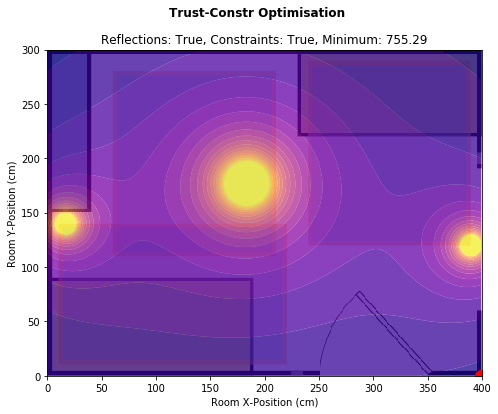

In [29]:
PlotTestDistribution(model.result.x, model.name, refl=model.refl, save_fig=model.save_fig, fig_name=model.name,
                         constrained=model.constrained)
